# whats_in_the_fridge (?) -- Technical Report
## Table of Contents <a id='table_of_contents'></a>
- <a href='#introduction'>I. Introduction</a>
- <a href='#problem_statement'>II. Problem Statement</a>
- <a href='#data_collection'>III. Data Collection</a>
- <a href='#data_cleaning'>IV. Data Cleaning</a>
- <a href='#eda'>V. Exploratory Data Analysis</a>
- <a href='#whats_in_the_fridge'>VI. whats_in_the_fridge</a>

# I. Introduction <a id='Introduction'></a>
Food Network has a library of over 65,000 recipes on its website at foodnetwork.com.  Each recipe has user submitted reviews and ratings, along with some explicit metrics (difficulty level, time to complete, yield, etc.).  foodnetwork.com also has some nice features, such as a recipe box where you can save recipes you like, and a grocery list, where you can add ingredients from recipes.  Lastly, foodnetwork.com has a basic recommendation system in place, with suggested recipes at the bottom of the recipe page you are currently on.  Despite these nice features, there are a number that we believe would benefit foodnetwork.com and its users.  In this project we set out to address these perceived feature gaps, and answer a number of questions through an exploration of the data from foodnetwork.com's recipes. 

# II. Problem Statement <a id='problem_statement'></a>

### Whats in the Fridge?
How many times have you gone into your kitchen, hungry, and said, "What should I make?...  I have these ingredients in my fridge, what should I cook tonight?" This was the first question we sought to address, as well as the main goal and inspiration for <a href='#whats_in_the_fridge'>whats_in_the_fridge</a>.

### What is the <i>True</i> rating of each recipe?
Each recipe on foodnetwork.com can be rated by users on a 0-5 star scale. This system seems to be inherently flawed however, given that a recipe with 1, 5-star rating has the same rating as a recipe with 10, 5-star ratings--or that the same recipe has a <i>higher</i> rating than a recipe with 100, 4-star ratings. So the second question and goal of this project was to determine a <b><i>true</i></b>, or <a href='#modeling'>projected rating</a> for each recipe, given the data we have on every other recipe. 

#### <a href='#table_of_contents'>Back to Table of Contents</a>

# III. Data Collection <a id='data_collection'></a>

Collecting data on each recipe from foodnetwork.com turned out to be a logistical nightmare, considering the time constraints of this project. Additionally, we were unable to use scrapy to extract data from each recipe page (which we will address and explain later).

## A. gather all the recipe urls <a id='get_urls'></a>
The first thing we did to collect our data was gather the recipe urls for all 65,000+ recipes at foodnetwork.com. In our first attempt to collect a list of recipe urls we used scrapy from the terminal, attempting to crawl through foodnetwork.com's a-z directory of recipes (http://www.foodnetwork.com/recipes/a-z.html). Food Network detected the use of our spiders and would either suspend us or redirect us to null pages. Our second attempt and method was to use scrapy in jupyter notebook and do the following:
1. create a list of a-z index urls (e.g. http://www.foodnetwork.com/recipes/a-z.D.1.html)
2. iterate through that list with scrapy, determine the range of pages for each a-z index, then create each url, and finally appending it to a list of urls (e.g. http://www.foodnetwork.com/recipes/a-z.R.23.html)
3. lastly, iterate through that list with scrapy and extract every recipe url for each page in each a-z index

This strategy was successful, rendering a final list with all 65,000+ recipe urls. We now had a starting point for collecting our final data set. The next goal was to write a function that would go through that list and extract all the information from each recipe.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
import time

In [ ]:
def get_az_urls(alphabet):
    
    # iterate through each letter in 'alphabet', create the a-z index urls
    for a in alphabet:
        url = "http://www.foodnetwork.com/recipes/a-z.%s.1.html" % a
        
        # extract the page_range for each a-z index url
        response = requests.get(url)
        HTML = response.text
        page_range = Selector(text=HTML).xpath("//div[@class='pagination']/ul/li/a/text()").extract()
        # append the page_range for each letter in alphabet to a list=page_ranges
        page_ranges.append(page_range)
        # sleep
        time.sleep(1)
    
    # zip each letter in 'alphabet' with its corresponding page_range in page_ranges
    for rng in page_ranges:
        letter_ranges.append(int(rng[-1]))
    letters_page_ranges = zip(alphabet, letter_ranges)
    
    # create a url for each a-z index, along with a page number, and append to a final url list=urls
    for element in letters_page_ranges:
        for i in range(element[1]):
            url_ = "http://www.foodnetwork.com/recipes/a-z.%s.%s.html" % (element[0], (i+1))
            urls.append(url_)

In [ ]:
# create an a-z index for the argument given to get_urls
alphabet = ['123','A','B','C','D','E','F','G','H','I','J','K','L',
            'M','N','O','P','Q','R','S','T','V','W','XYZ']

# get_az_urls(alphabet)

In [ ]:
def get_recipe_urls(urls):
    
    # initiate a blank list to collect recipe urls
    recipe_urls = []
    
    response = requests.get(urls)
    HTML = response.text
    
    # extract recipe names
    recipe_name = Selector(text=HTML).xpath("//li[@class='col18']/span[@class='arrow']/a/text()").extract()
    for recipe in recipe_name:
        recipe_names.append(recipe)
    
    # extract recipe urls
    recipe_url = Selector(text=HTML).xpath("//li[@class='col18']/span[@class='arrow']/a/@href").extract()
    for recipe_url_ in recipe_url:
        recipe_urls.append('http://www.foodnetwork.com'+recipe_url_)
    time.sleep(1)

## B. get the recipe data <a id='get_details'></a>
In our first attempt to extract all the information from each recipe page, we once again wrote a function utilizing scrapy in jupyter notebook. The results and data extracted however, were incomplete. After examining the source code on foodnetwork.com's recipe pages, we determined that there was a significant amount of dynamic content on those pages operating with javascript, including some of the fields we were trying to extract. As a result, our function would move on to the next page before data we were trying to collect had fully rendered. Even after building delays into our function, the results were inconsistent and incomplete. 

To overcome this extraction barrier, we used the selenium webdriver. This program opened each web page and allowed it to fully render before extracting the information we needed. While it proved to be effective and successfully extracted all the fields we desired for our dataset, it took about 8 seconds for each page to fully render. With over 65,000 recipes to collect, at 8 seconds per recipe, and 3600 seconds per hour, that is over 144 hours--just over 6 days if running continuously. This is the "logistical nightmare" we opened this section with. In order to collect the data, we had to run 2-3 of our crawlers nearly continuously in batches, clearing our kernel cache for every 2-3 thousand recipes so the computer would not crash. The whole process took over a week, but the final result was a [63868 x 15] dataframe full of glorious recipe data.

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chromedriver = '/Users/kylemulle/Downloads/chromedriver' # change path as needed

chop = webdriver.ChromeOptions()
chop.add_extension('/Users/kylemulle/Downloads/AdBlock_v3.1.1.crx') # change path as needed

browser = webdriver.Chrome(executable_path = chromedriver, chrome_options=chop)

In [ ]:
def get_details(url):
                
    recipe = []
    recipe_details = []
    
    try: 
        browser.get(url)
        HTML = browser.page_source
        
        # url
        recipe.append(url)

        # recipe name
        name = Selector(text=HTML).xpath("//div[@class='tier-3 title']/h1/text()").extract()
        recipe.append(name)

        # ingredients
        ingredients = Selector(text=HTML).xpath("//ul/li/div[@class='box-block']/text()").extract()
        recipe.append(ingredients)

        # yield
        yield_ = Selector(text=HTML).xpath("//div[@class='difficulty']/dl[1]/dd/text()").extract()
        recipe.append(yield_)

        # difficulty
        difficulty = Selector(text=HTML).xpath("//div[@class='difficulty']/dl[2]/dd/text()").extract()
        recipe.append(difficulty)

        # total time
        time_total = Selector(text=HTML).xpath("//div[@class='cooking-times']/dl/dd[@class='total']/text()").extract()
        recipe.append(time_total)
        
        # preparation time
        time_prep = Selector(text=HTML).xpath("//div[@class='cooking-times']/dl/dd[2]/text()").extract()
        recipe.append(time_prep)
        
        # cook time/inactive time 
        time_cook_3 = Selector(text=HTML).xpath("//div[@class='cooking-times']/dl/dd[3]").extract()
        time_cook_4 = Selector(text=HTML).xpath("//div[@class='cooking-times']/dl/dd[4]").extract()
        # w/ inactive time
        if time_cook_4 != []:
            recipe.append(time_cook_3) # inactive time
            recipe.append(time_cook_4) # cook time
        # NO inactive time
        else:
            recipe.append(time_cook_4) # null result
            recipe.append(time_cook_3) # cook time
        
        # categories
        categories = Selector(text=HTML).xpath("//ul[@class='categories']/li/a/text()").extract()
        recipe.append(categories)

        # rating
        rating = Selector(text=HTML).xpath("//a[contains(@class, 'community-rating-stars')]//@title").extract()
        recipe.append(rating)

        # ratings
        ratings = Selector(text=HTML).xpath("//div[@class='col18']/section[@class='review-rating section']\
        /a[@class='community-rating-stars']/div[@class='gig-rating-ratingsum']/text()").extract()
        recipe.append(ratings)

        # directions
        directions = Selector(text=HTML).xpath("//ul[@class='recipe-directions-list']/li/p").extract()
        recipe.append(directions)

        # chef
        chef = Selector(text=HTML).xpath("//div[@class='col10 directions']/p[@class='copyright']/text()").extract()
        recipe.append(chef)
        
        # photo
        image = Selector(text=HTML).xpath("//section[@class='single-photo-recipe']\
        /a[@class='ico-wrap']/img/@src").extract()
        image_ = Selector(text=HTML).xpath("//div[@class='ico-wrap']/img/@src").extract() 
        if image != []:
            recipe.append(image)
        else:
            recipe.append(image_)

        recipe_details.append(recipe)
        
    except:
        print 'FAIL:  %s -' % (datetime.strftime(datetime.now(), '%H:%M:%S')), url
        pass


The only thing left to do at this point was convert appropriate index for each row in the recipe_details list to dictionary key:value pairs, and convert the dictionary into a dataframe. View the full <a href='https://github.com/kylemullet/projects/blob/master/whats_in_the_fridge/data_collection.ipynb'>source code</a>.

<a id='data_cleaning'></a>
#### <a href='#table_of_contents'>Table of Contents</a>

# IV. Data Cleaning 
Our raw dataset consisted entirely of strings for every column or feature. While the data cleaning process was no doubt tedious and time consuming, it was done almost exclusively using string functions, followed by converting datatypes when necessary (such as string to float). Inasmuch we will not go into great detail in this report, but you can follow the link to check out the <a href='https://github.com/kylemullet/projects/blob/master/whats_in_the_fridge/data_cleaning.ipynb'>source code</a>.

<a id='eda'></a>
<a id='eda_table_of_contents'></a>
#### <a href='#table_of_contents'>Table of Contents</a>
# V. Exploratory Data Analysis
Use the following link to view the full EDA <a href='https://github.com/kylemullet/projects/blob/master/whats_in_the_fridge/eda.ipynb'>source code</a>.

## EDA Table of Contents 
- <a href='#overview'>Overview</a>
- <a href='#ratings'>Ratings (popularity)</a>
- <a href='#rating'>Rating (score)</a>
- <a href='#difficulty'>Difficutly</a>
- <a href='#ingredients'>Ingredients (numuber)</a>
- <a href='#modeling'>Modeling</a>
    - <a href='#kNN'>Logistic Regression, kNN</a>
    - <a href='#decision_tree'>Decision Tree Classifier</a>
    - <a href='#random_forest'>Random Forest</a>

# Overview <a id='overview'></a>
Examining our data from a high level, there do not appear to be many meaningful correlations. The heatmap below shows that most of our data falls in the middle of our gradient, indicating low correlation values. Many of the more highly correlated features are either implicitly correlated (e.g. Prep Time v Total Time), or are relationships we would expect to see (e.g. Number of Ingredients v Difficulty). 

To answer the question set forth in this project--What is the <i>true</i>, or projected, rating of a recipe?--we are mostly concerned with the relationship between between rating (quality) and ratings (popularity) relative to the other fields in our dataset. This is our approach for EDA in this project, examining various aspects of our data throught the lense of recipe rating and ratings.

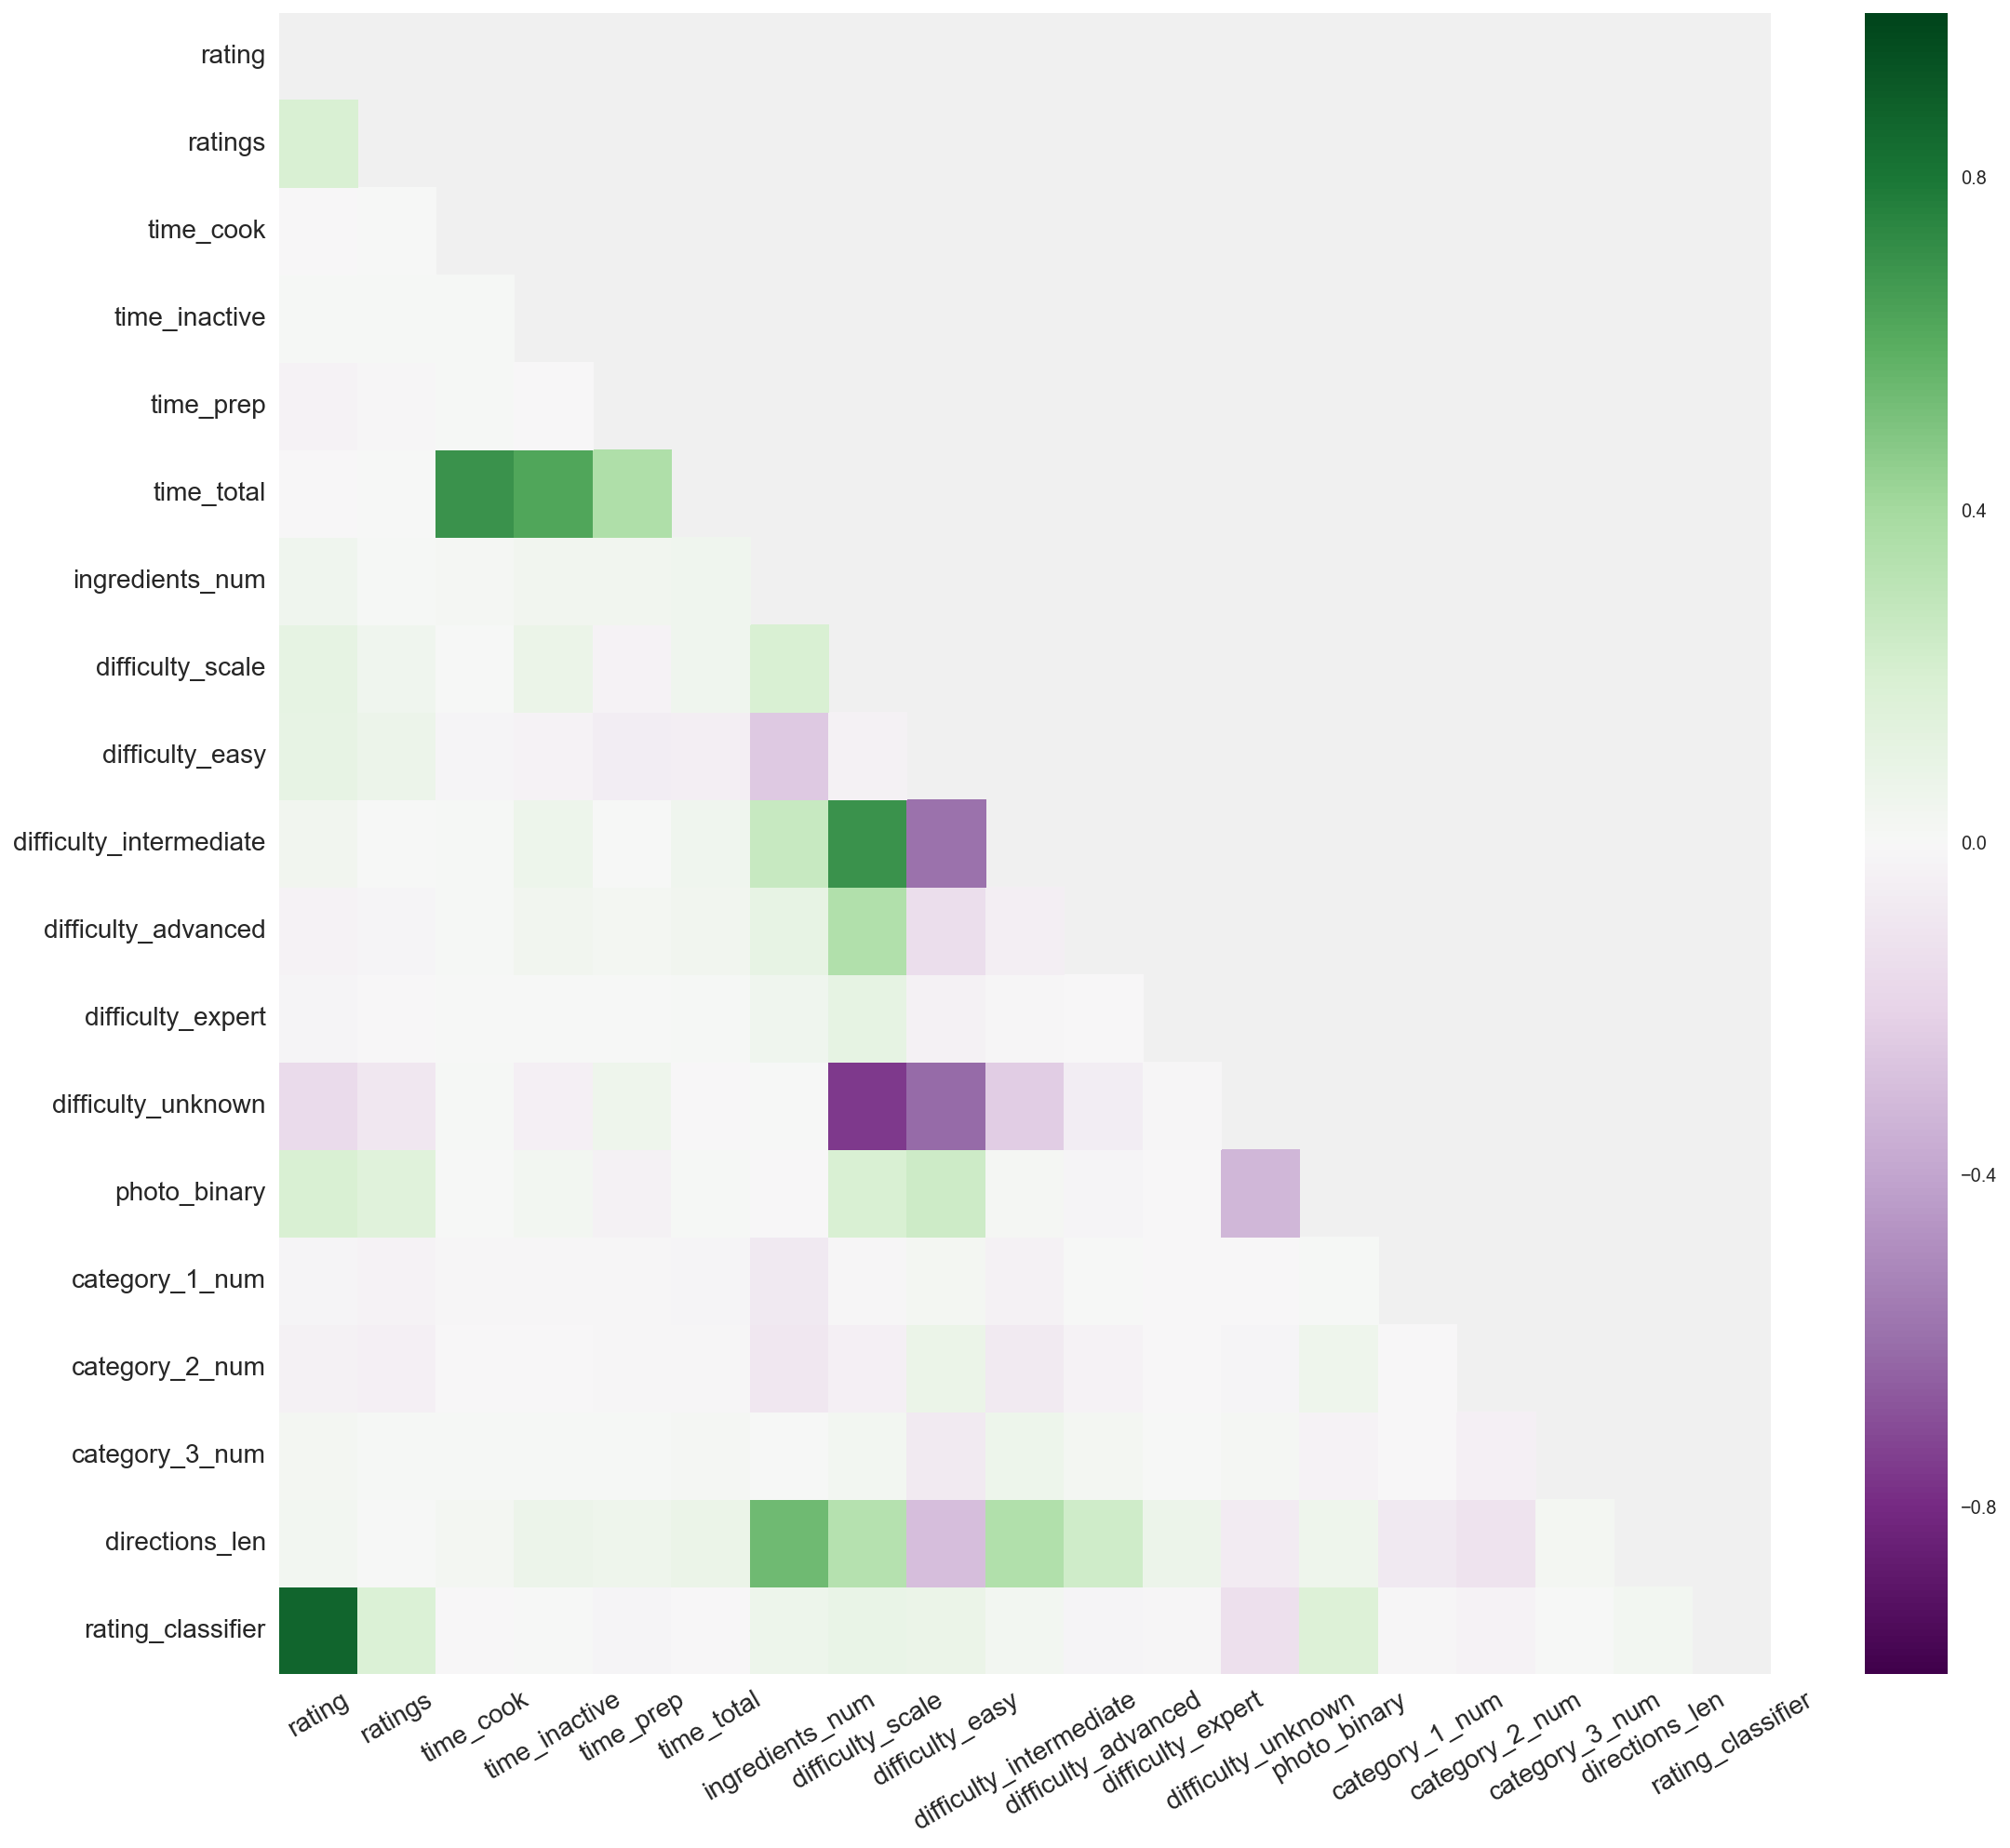

In [225]:
def heatmap(Data):
    correlations = Data.corr()
    fig, ax = plt.subplots(figsize=(16,16))
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(correlations, cmap='PRGn' ,mask=mask)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    plt.show()

heatmap(df)

In [8]:
df.describe()

,rating,ratings,time_cook,time_inactive,time_prep,time_total,ingredients_num,difficulty_scale,difficulty_easy,difficulty_intermediate,difficulty_advanced,difficulty_expert,difficulty_unknown,photo_binary,category_1_num,category_2_num,category_3_num,directions_len
count,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000
mean,3.250637,16.827805,45.156715,38.185516,30.327601,113.669833,11.819292,1.017739,0.614049,0.180436,0.013390,0.000663,0.191463,0.538181,110.246313,42.501325,88.632383,987.550992
std,2.088610,59.165110,398.969127,362.243855,203.347840,580.375896,6.288360,0.656593,0.486823,0.384553,0.114937,0.025734,0.393456,0.498544,90.814267,56.390682,84.159744,678.160942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000
25%,0.000000,0.000000,5.000000,0.000000,10.000000,20.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,5.000000,15.000000,523.000000
50%,4.500000,3.000000,20.000000,0.000000,15.000000,45.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,89.000000,19.000000,72.000000,854.000000
75%,5.000000,12.000000,40.000000,0.000000,25.000000,90.250000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,163.000000,55.000000,128.000000,1273.000000
max,5.000000,5238.000000,59940.000000,30420.000000,30240.000000,59955.000000,71.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,423.000000,424.000000,424.000000,11065.000000


<a id='ratings'></a>
### <a href='#eda_table_of_contents'>back to EDA table of contents</a> 

# Ratings (popularity) 
Not too surprisingly, the recipes on foodnetwork.com are a lot like all the other media and things we consume--a handful of recipes are wildly popular, while the vast majority are relatively (or literally) unknown. Of the 58,852 recipes in our dataset, the ratings are skewed <b><i>heavily</i></b> right, with 75% of recipes having 12 ratings or fewer, and 26.94% have zero ratings. As the data below shows, at virtually every value for ratings, the number of recipes goes down (most visible in second row of plots, where our recipes data is subsetted for recipes with 0 < ratings <= 20).


Recipes ratings == ALL

count    58852.000000
mean        16.827805
std         59.165110
min          0.000000
25%          0.000000
50%          3.000000
75%         12.000000
max       5238.000000
Name: ratings, dtype: float64 

Recipes ratings == 0
15853 (26.94%)


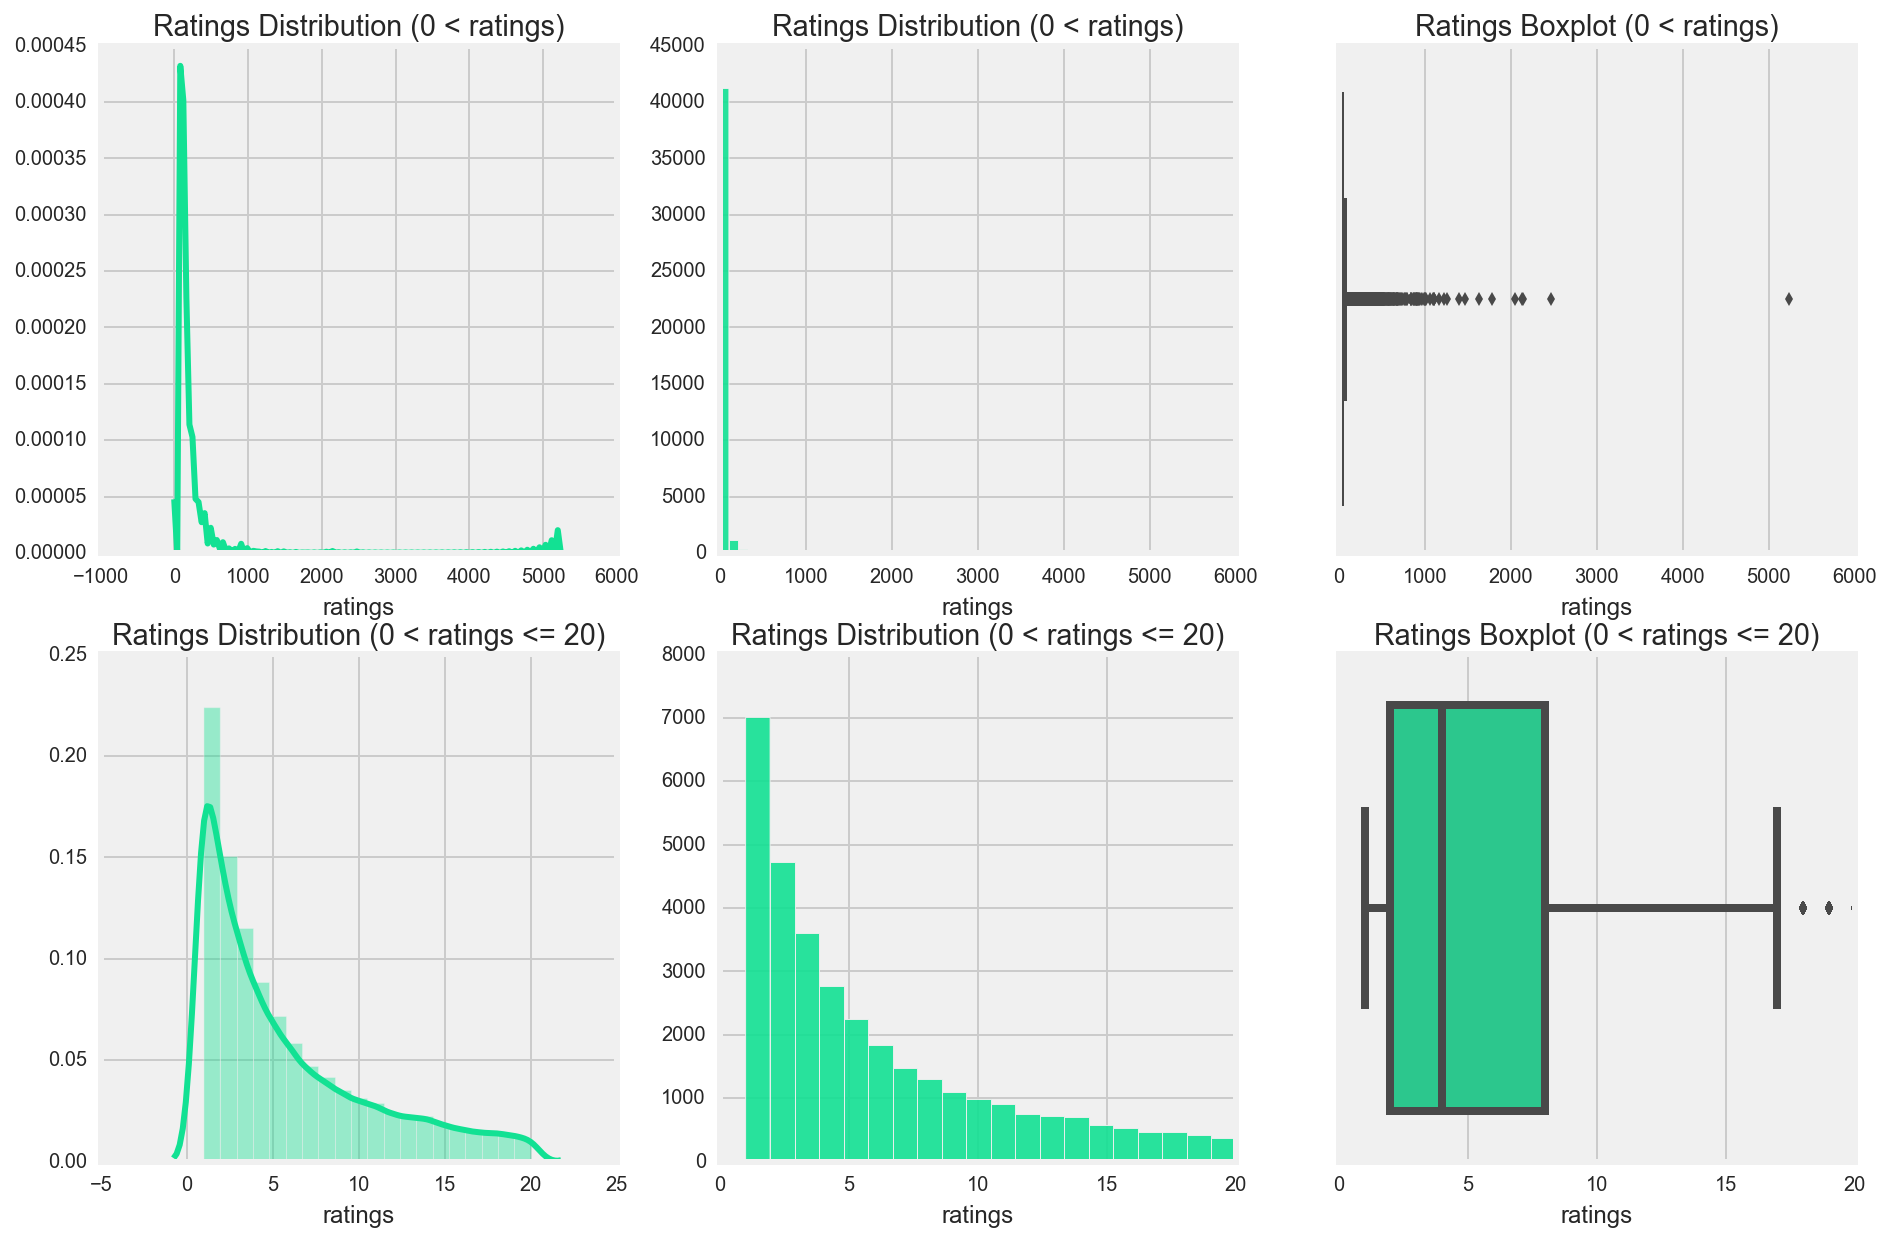

In [216]:
df_rs = df[df['ratings'] > 0]
df_0rs = df[df['ratings'] == 0]

print '\nRecipes ratings == ALL\n\n', df['ratings'].describe(), '\n'
print "Recipes ratings == 0\n", df_0rs.shape[0], \
'(%.2f%%)' % (float(df_0rs.shape[0])/df.shape[0]*100.)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
random = colors[int(len(colors)*np.random.rand())]
# rating distribution
sns.distplot(df_rs.ratings, bins=None, hist=False, kde=True, kde_kws={"lw":3, 'shade':False}, 
             color=random, ax=axs[0,0])
sns.distplot(df_rs.ratings, bins=None, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[0,1])
sns.boxplot(x='ratings', data=df_rs, color=random, ax=axs[0,2])
# rating distribution for recipes with ratings > 0
sns.distplot(df_rs.ratings[df_rs.ratings <= 20], bins=20, hist=True, kde=True, kde_kws={"lw":3, 'shade':False},
             color=random, ax=axs[1,0])
sns.distplot(df_rs.ratings[df_rs.ratings <= 20], bins=20, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[1,1])
sns.boxplot(x='ratings', data=df_rs[df_rs.ratings <= 20], color=random, ax=axs[1,2])

axs[0,0].set_title('Ratings Distribution (0 < ratings)')
axs[0,1].set_title('Ratings Distribution (0 < ratings)')
axs[0,2].set_title('Ratings Boxplot (0 < ratings)')
axs[1,0].set_title("Ratings Distribution (0 < ratings <= 20)")
axs[1,1].set_title("Ratings Distribution (0 < ratings <= 20)")
axs[1,2].set_title('Ratings Boxplot (0 < ratings <= 20)')
plt.show()

The graphs below again demonstrate how heavily skewed our dataset is, showing the relationship between percentile and ratings, and vice versa. 

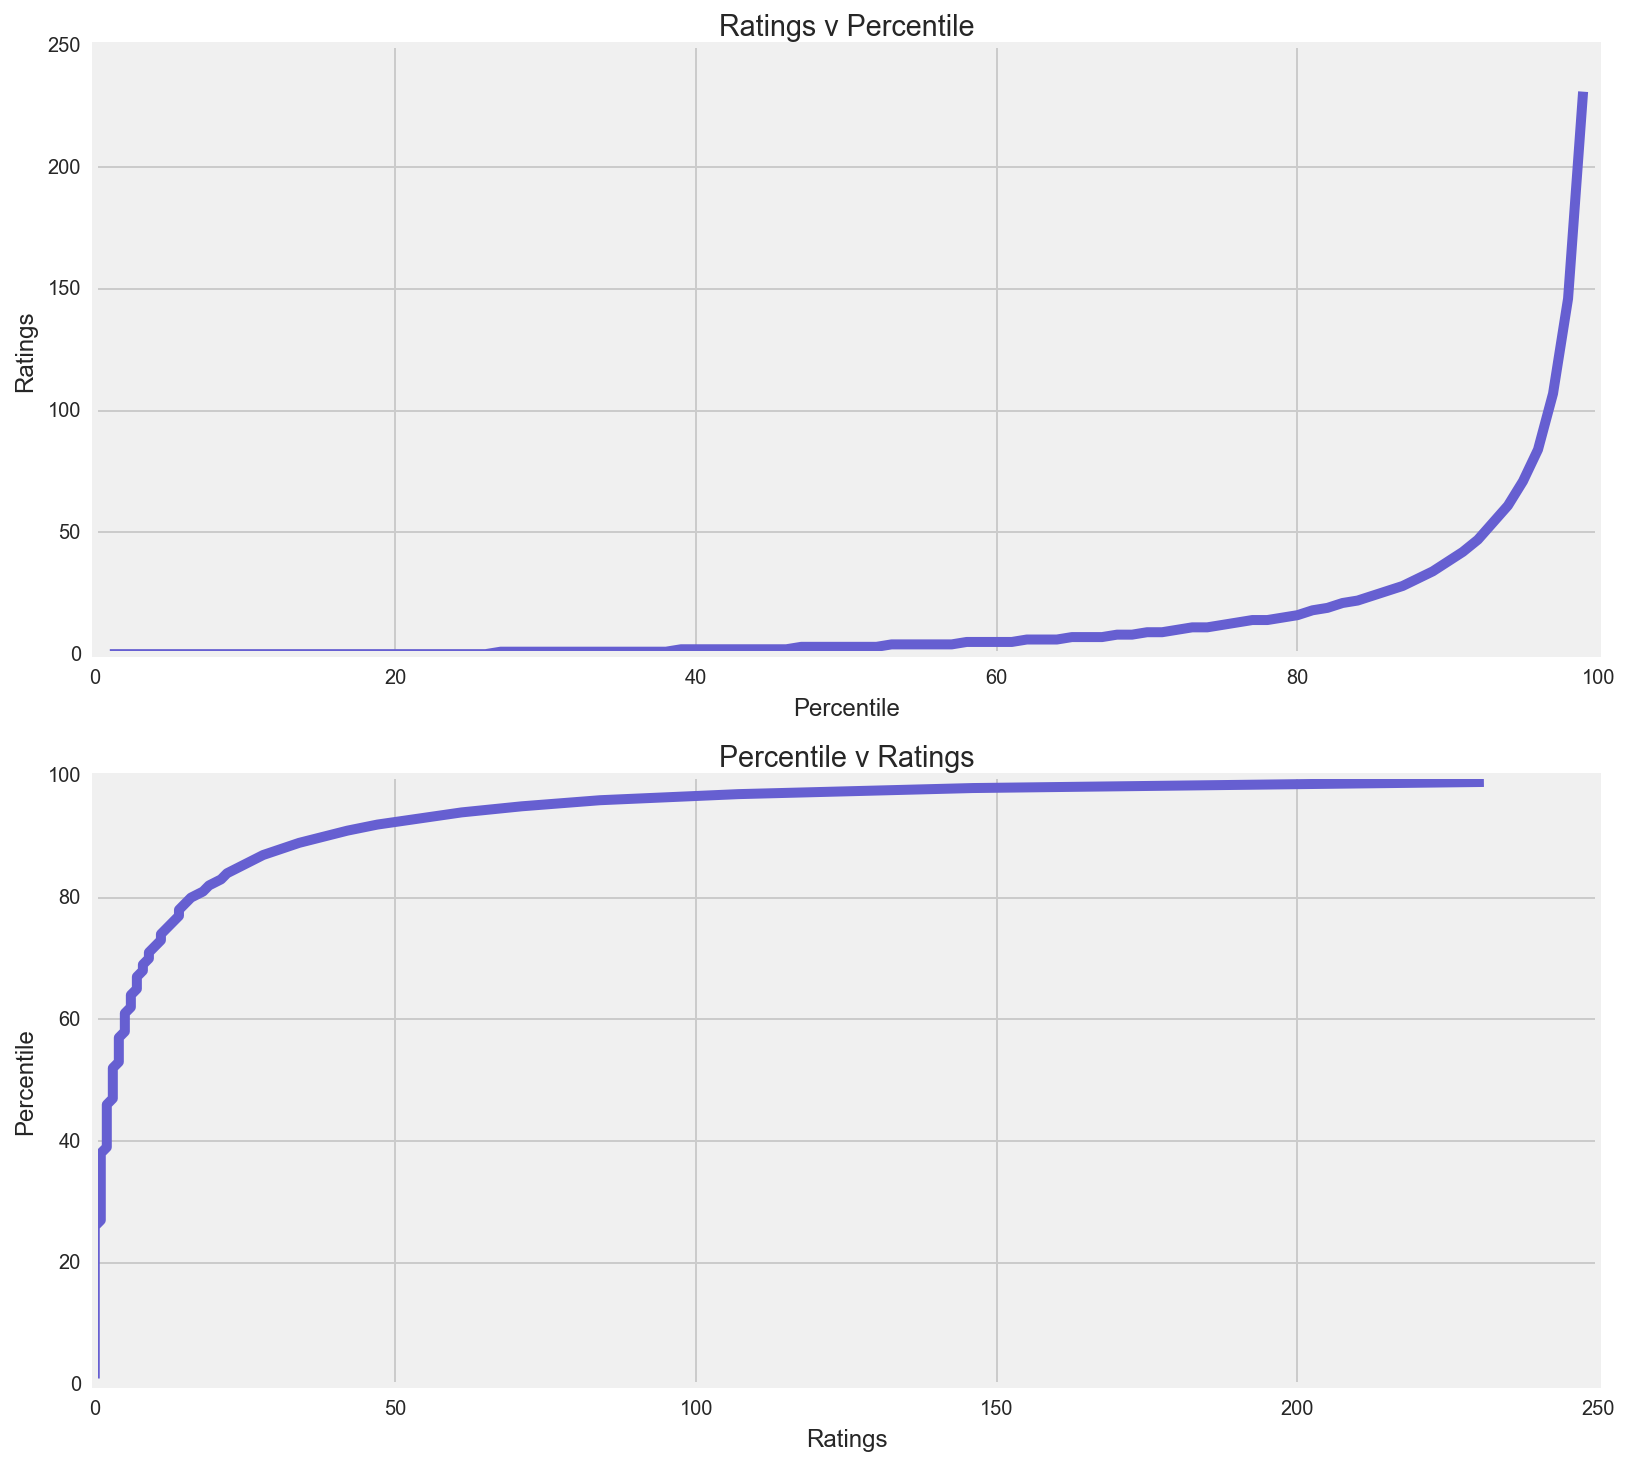

In [224]:
percentiles = range(1,100)
rating_percentiles = np.percentile(df.ratings.values, percentiles)
# random color
random = colors[int(len(colors)*np.random.rand())]
fig, ax = plt.subplots(2, figsize=(12,12))
ax[0].plot(percentiles, rating_percentiles, color=random, lw=5)
ax[0].set_xlabel('Percentile')
ax[0].set_ylabel('Ratings')
ax[0].set_title('Ratings v Percentile')
ax[1].plot(rating_percentiles, percentiles, color=random, lw=5)
ax[1].set_ylabel('Percentile')
ax[1].set_xlabel('Ratings')
ax[1].set_title('Percentile v Ratings')

plt.show()

In [81]:
print np.percentile(df.ratings.values, 75)
print stats.percentileofscore(df.ratings.values, 12)

12.0
75.0977027119


## Ratings v Rating
Not surprisingly, recipe ratings increase with recipe rating.

<i>**Excluded from the plot below are recipes with ratings==0 (it is implicit that 0 ratings recipes have a rating of 0)</i>

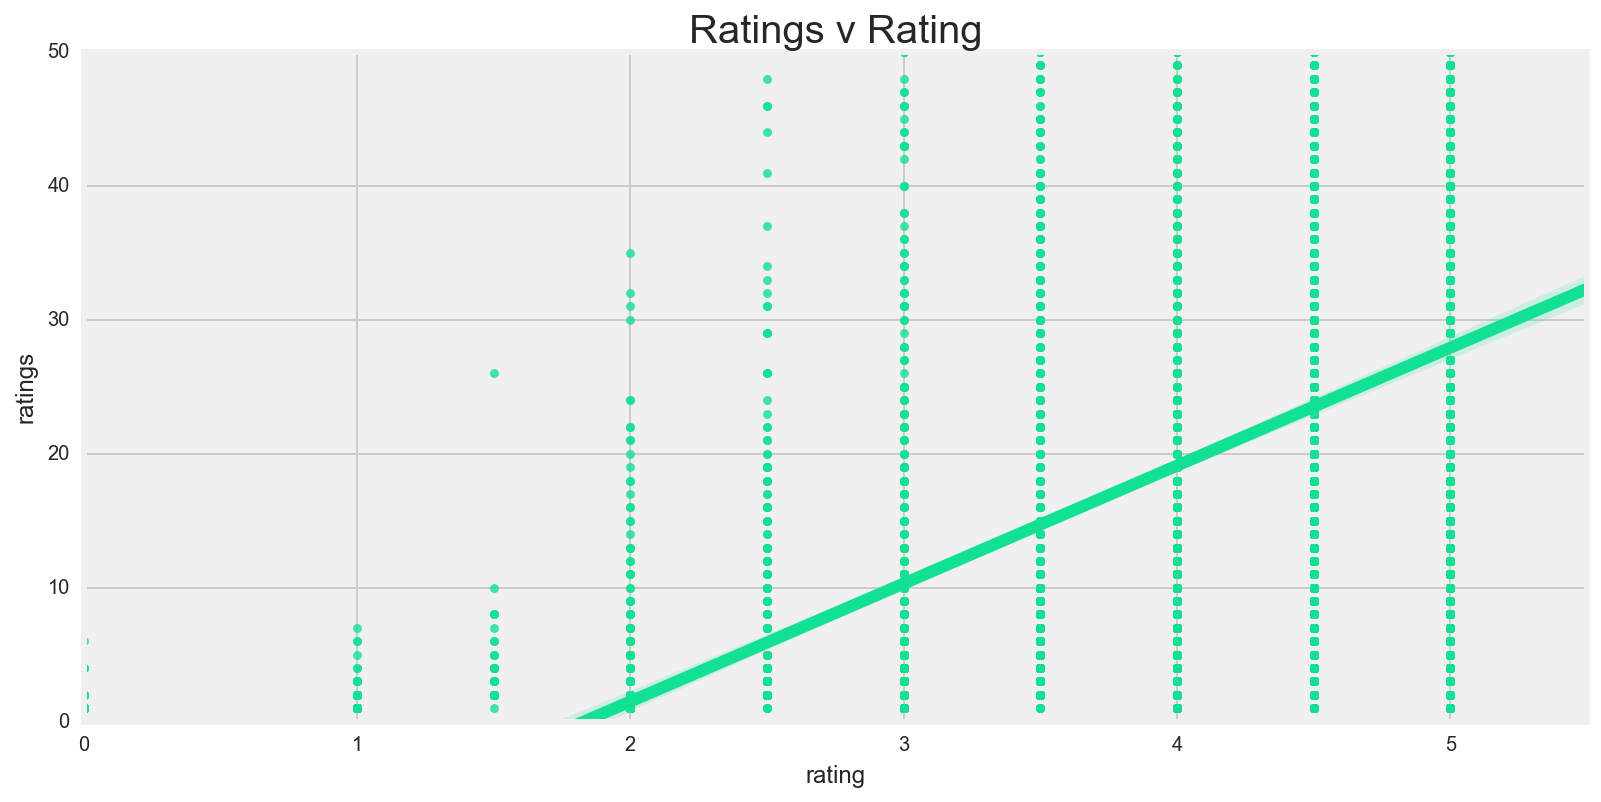

In [249]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="rating", y="ratings", data=df_rs, fit_reg=True, color=random)
ax.set_title('Ratings v Rating', fontsize=20)
ax.set_xlim([0,5.5])
ax.set_ylim([0,50])
plt.show()

## Ratings v Difficulty*
Perhaps indicative of the abundance and hype around recipes that are quick and easy (think <a href='https://www.facebook.com/buzzfeedtasty/'>Tasty</a>, or just look at the next section), the number of ratings tends to be higher for less difficult recipes.

*<i>Recipe difficulty == Unknown (difficulty_scale == 0) is treated as its own special category and thus has been left out of the regression plots shown below our distribution</i>

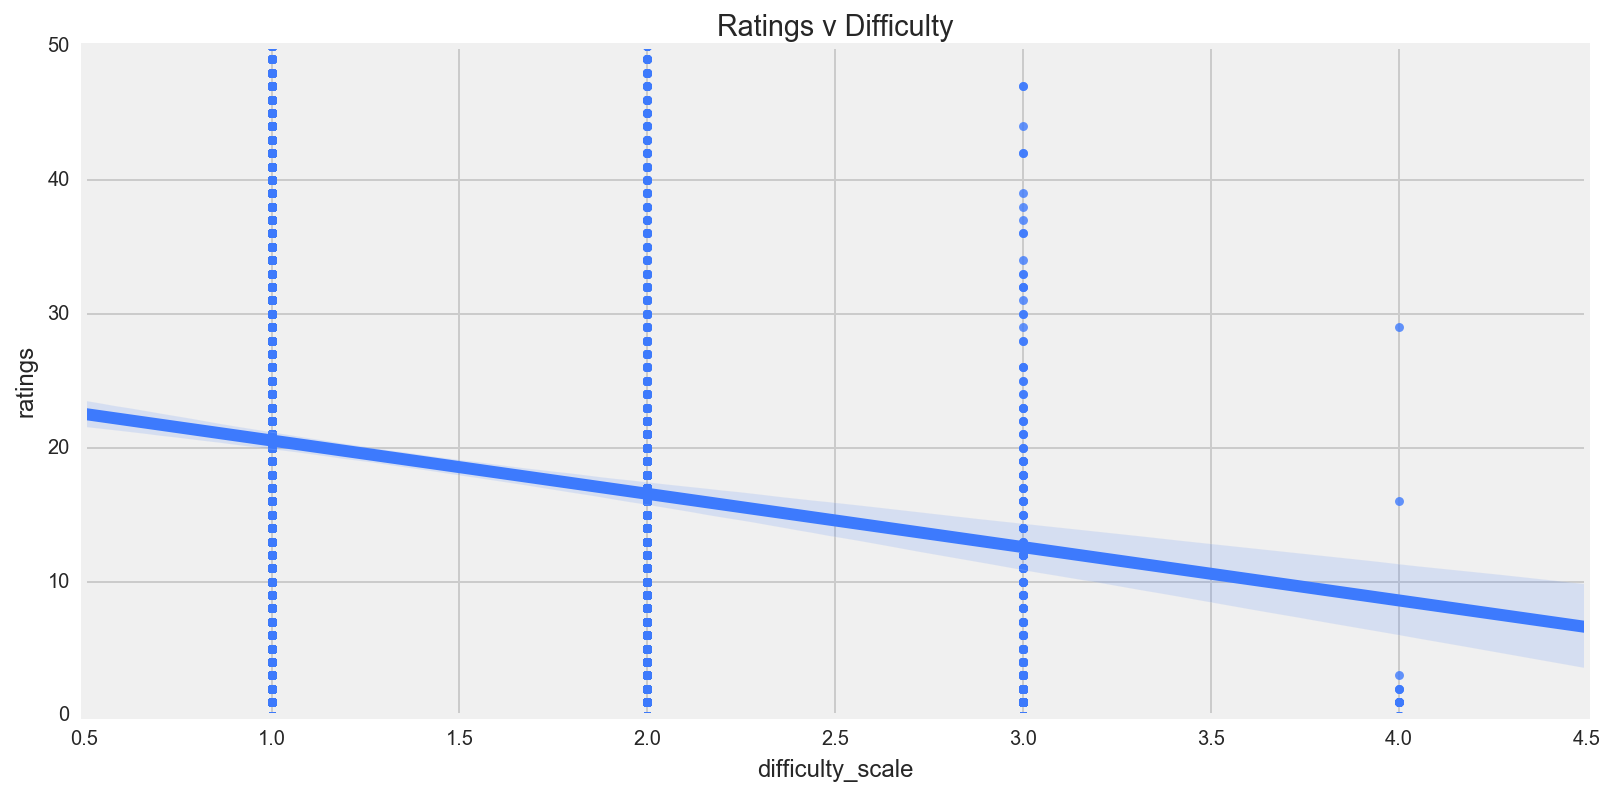

In [264]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="difficulty_scale", y="ratings", data=df[df.difficulty_scale != 0], fit_reg=True, color=random)
ax.set_title('Ratings v Difficulty')
ax.set_xlim([0.5,4.5])
ax.set_ylim([0,50])
plt.show()

### Ratings v Difficulty = Easy
As the number of ratings go up, it is fairly reliable to assume that it is an easy recipe.

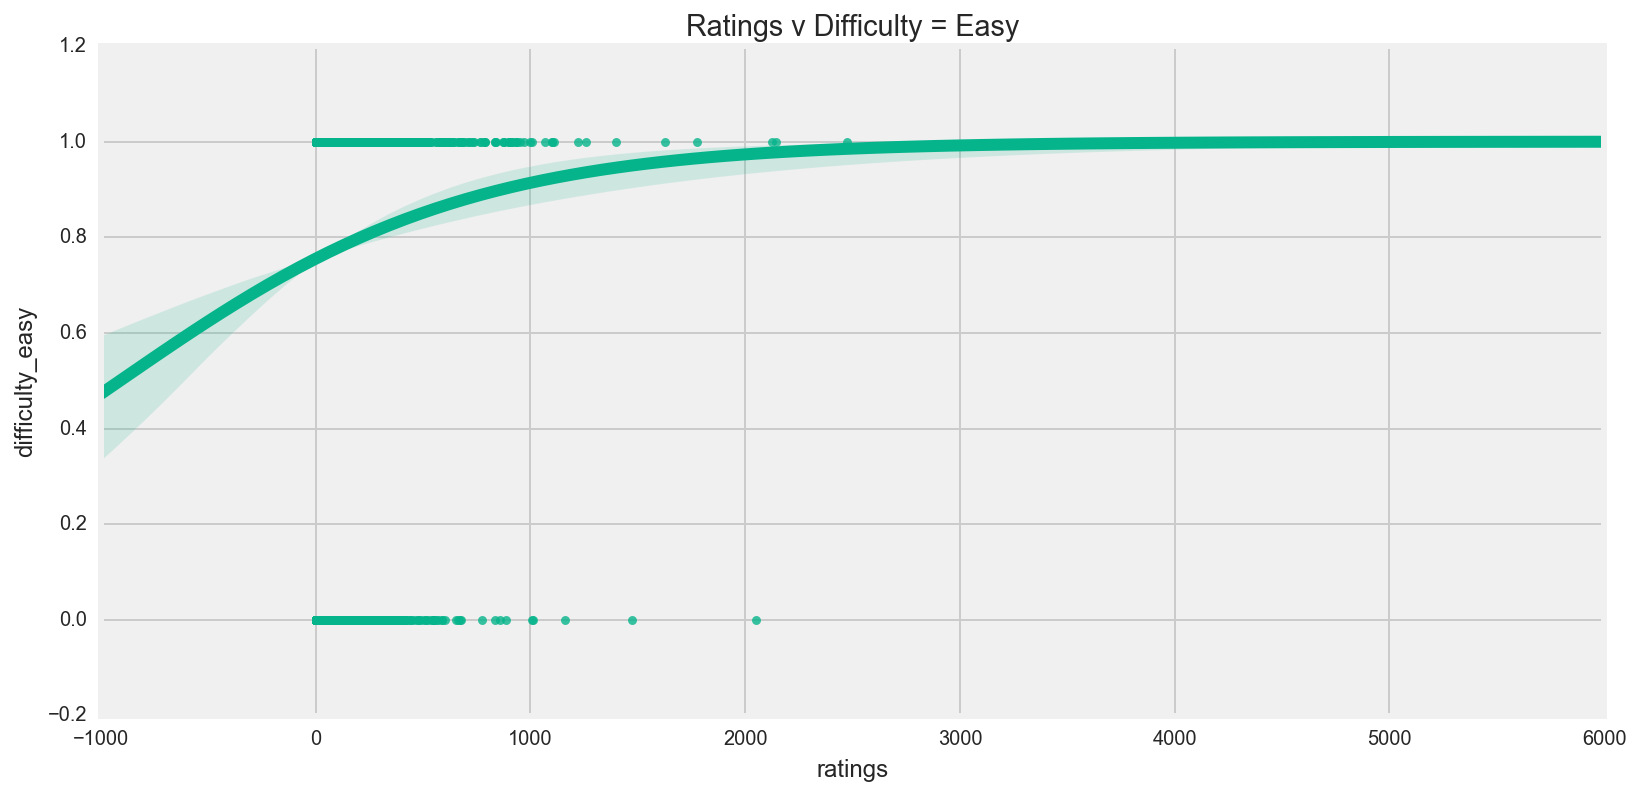

In [265]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_easy", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Easy')
plt.show()

### Ratings v Difficulty = Intermediate
We start to see the shift in the difficulty scale based on ratings here, and it continues for each successive level of difficulty

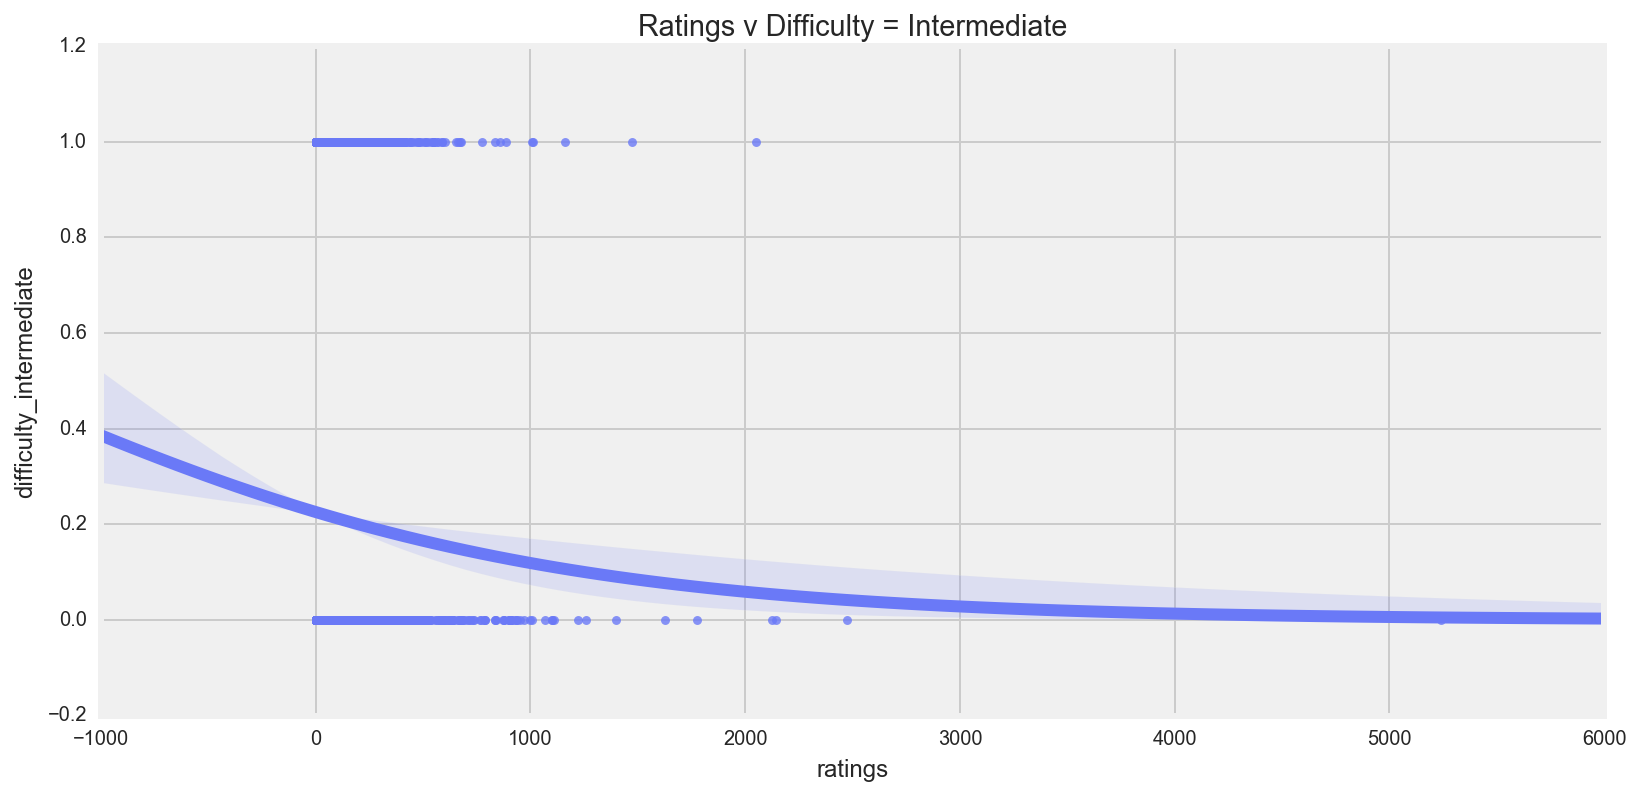

In [266]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_intermediate", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Intermediate')
plt.show()

## Ratings v Photo
It is said that presentation is an important factor in how things taste--(in theory) pretty things tend to taste better. Apparently presentation is as important when deciding what to make as when eating something. Recipes with photos have much more ratings than recipes without.

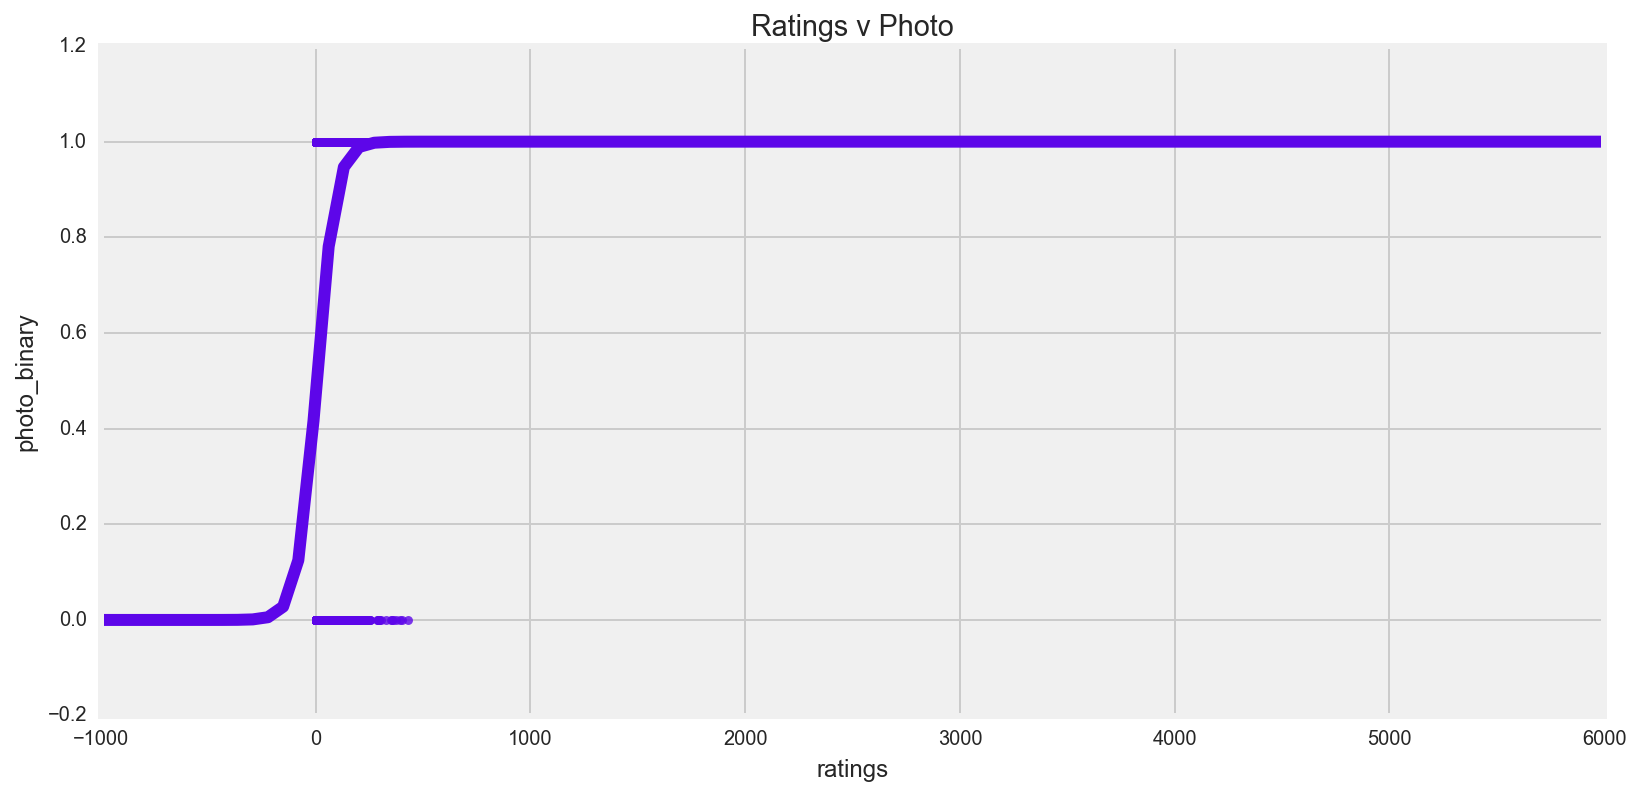

In [172]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="photo_binary", data=df, fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Photo')
plt.show()

## Ratings v Ingredients (number)
The number of ingredients doesn't appear to have much of an effect on the number of ratings a recipe receives, but there is a positive correlation.

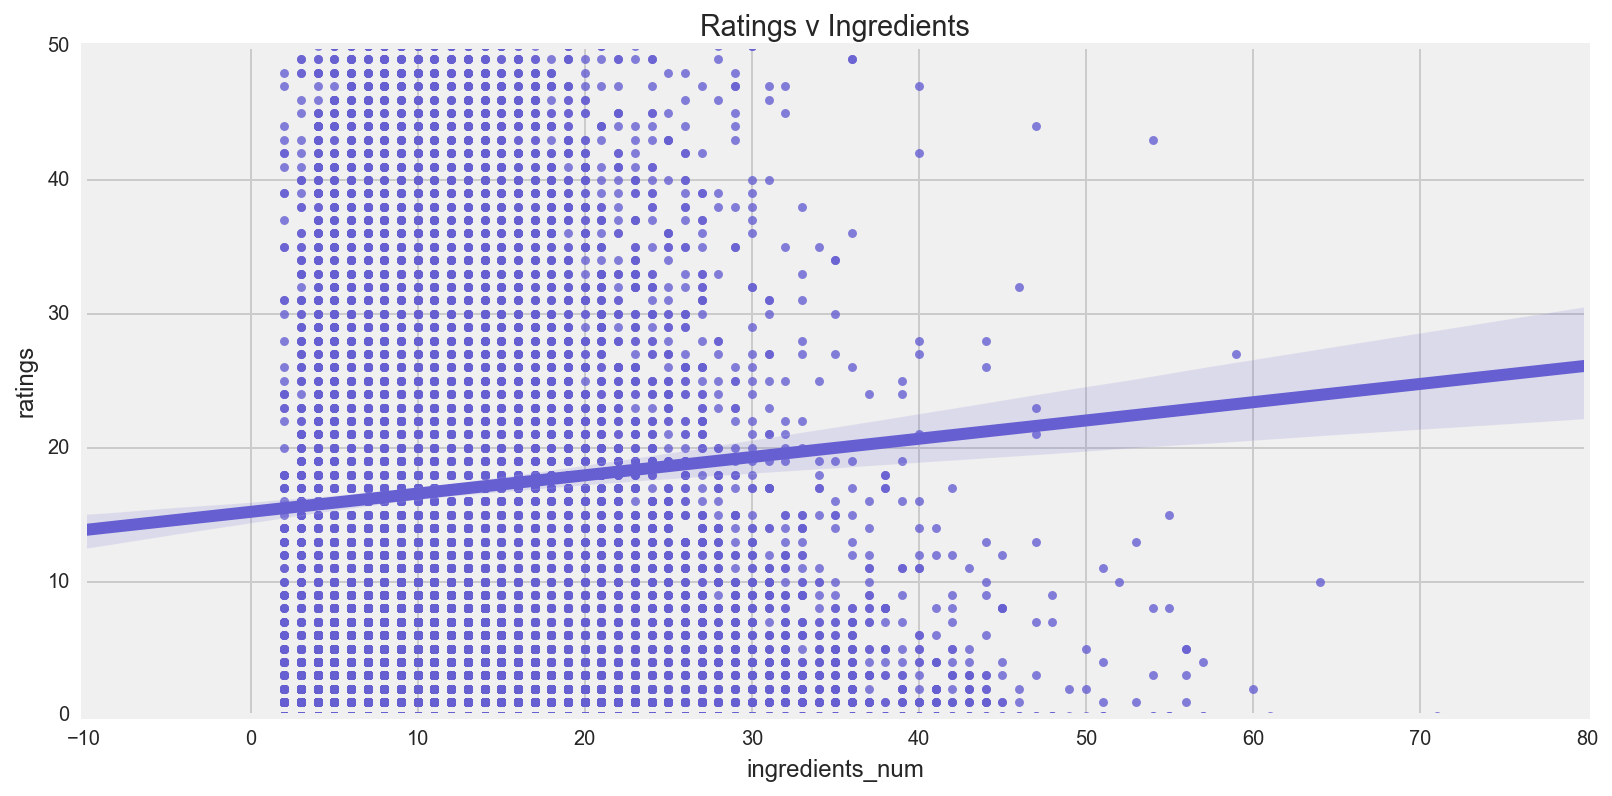

In [283]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="ratings", data=df, fit_reg=True, color=random)
ax.set_title('Ratings v Ingredients')
ax.set_ylim([0,50])
plt.show()

### The 10 most popular recipes on foodnetwork.com

In [301]:
df[['name','chef','difficulty','ratings','rating']].sort_values('ratings',ascending=False).head(10)

,name,chef,difficulty,ratings,rating
22377,GOOD EATS ROAST TURKEY,alton brown also featured in food network maga...,Easy,5238.0,5.0
2570,BAKED FRENCH TOAST CASSEROLE WITH MAPLE SYRUP,paula deen,Easy,2473.0,4.5
40831,PUMPKIN GOOEY BUTTER CAKES,paula deen,Easy,2142.0,5.0
34679,NOT YO' MAMA'S BANANA PUDDING,paula deen,Easy,2125.0,5.0
3632,BEATTY'S CHOCOLATE CAKE,barefoot contessa at home,Intermediate,2049.0,5.0
37196,PEACH COBBLER,paula deen,Easy,1777.0,4.5
13990,CORN CASSEROLE,paula deen,Easy,1627.0,5.0
29196,LASAGNA ROLLS,giada de laurentiis,Intermediate,1473.0,5.0
10146,CHICKEN PICCATA,giada de laurentiis,Easy,1397.0,5.0
34945,OLD-FASHIONED MEAT LOAF- A.K.A 'BASIC' MEAT LOAF,paula deen,Easy,1257.0,5.0


<a id='rating'></a>

### <a href='#eda_table_of_contents'>back to EDA table of contents</a>

# Rating (score) 
One of the first things we notice about recipe rating is how heavily weighted 0 and 5-star ratings are in our dataset.  As seen below, recipe rating, like recipe ratings has a a heavily skewed distribution. One of the main problems we see with the rating system is that a recipe with 1 5-star rating is objectively equivalent to a recipe with 10 5-star ratings, and objectively better than a recipe with 100 4-star ratings. Furthermore, the recipes on foodnetwork.com are eith very well curated or the users are easy to please--by far, the most common rating given by users is a 5.0. At first glance, it appears that 0 is the second highest rating, but when we subset for recipes with 1 or more ratings, we find that nearly all the 0 rated recipes were ones with 0 ratings.

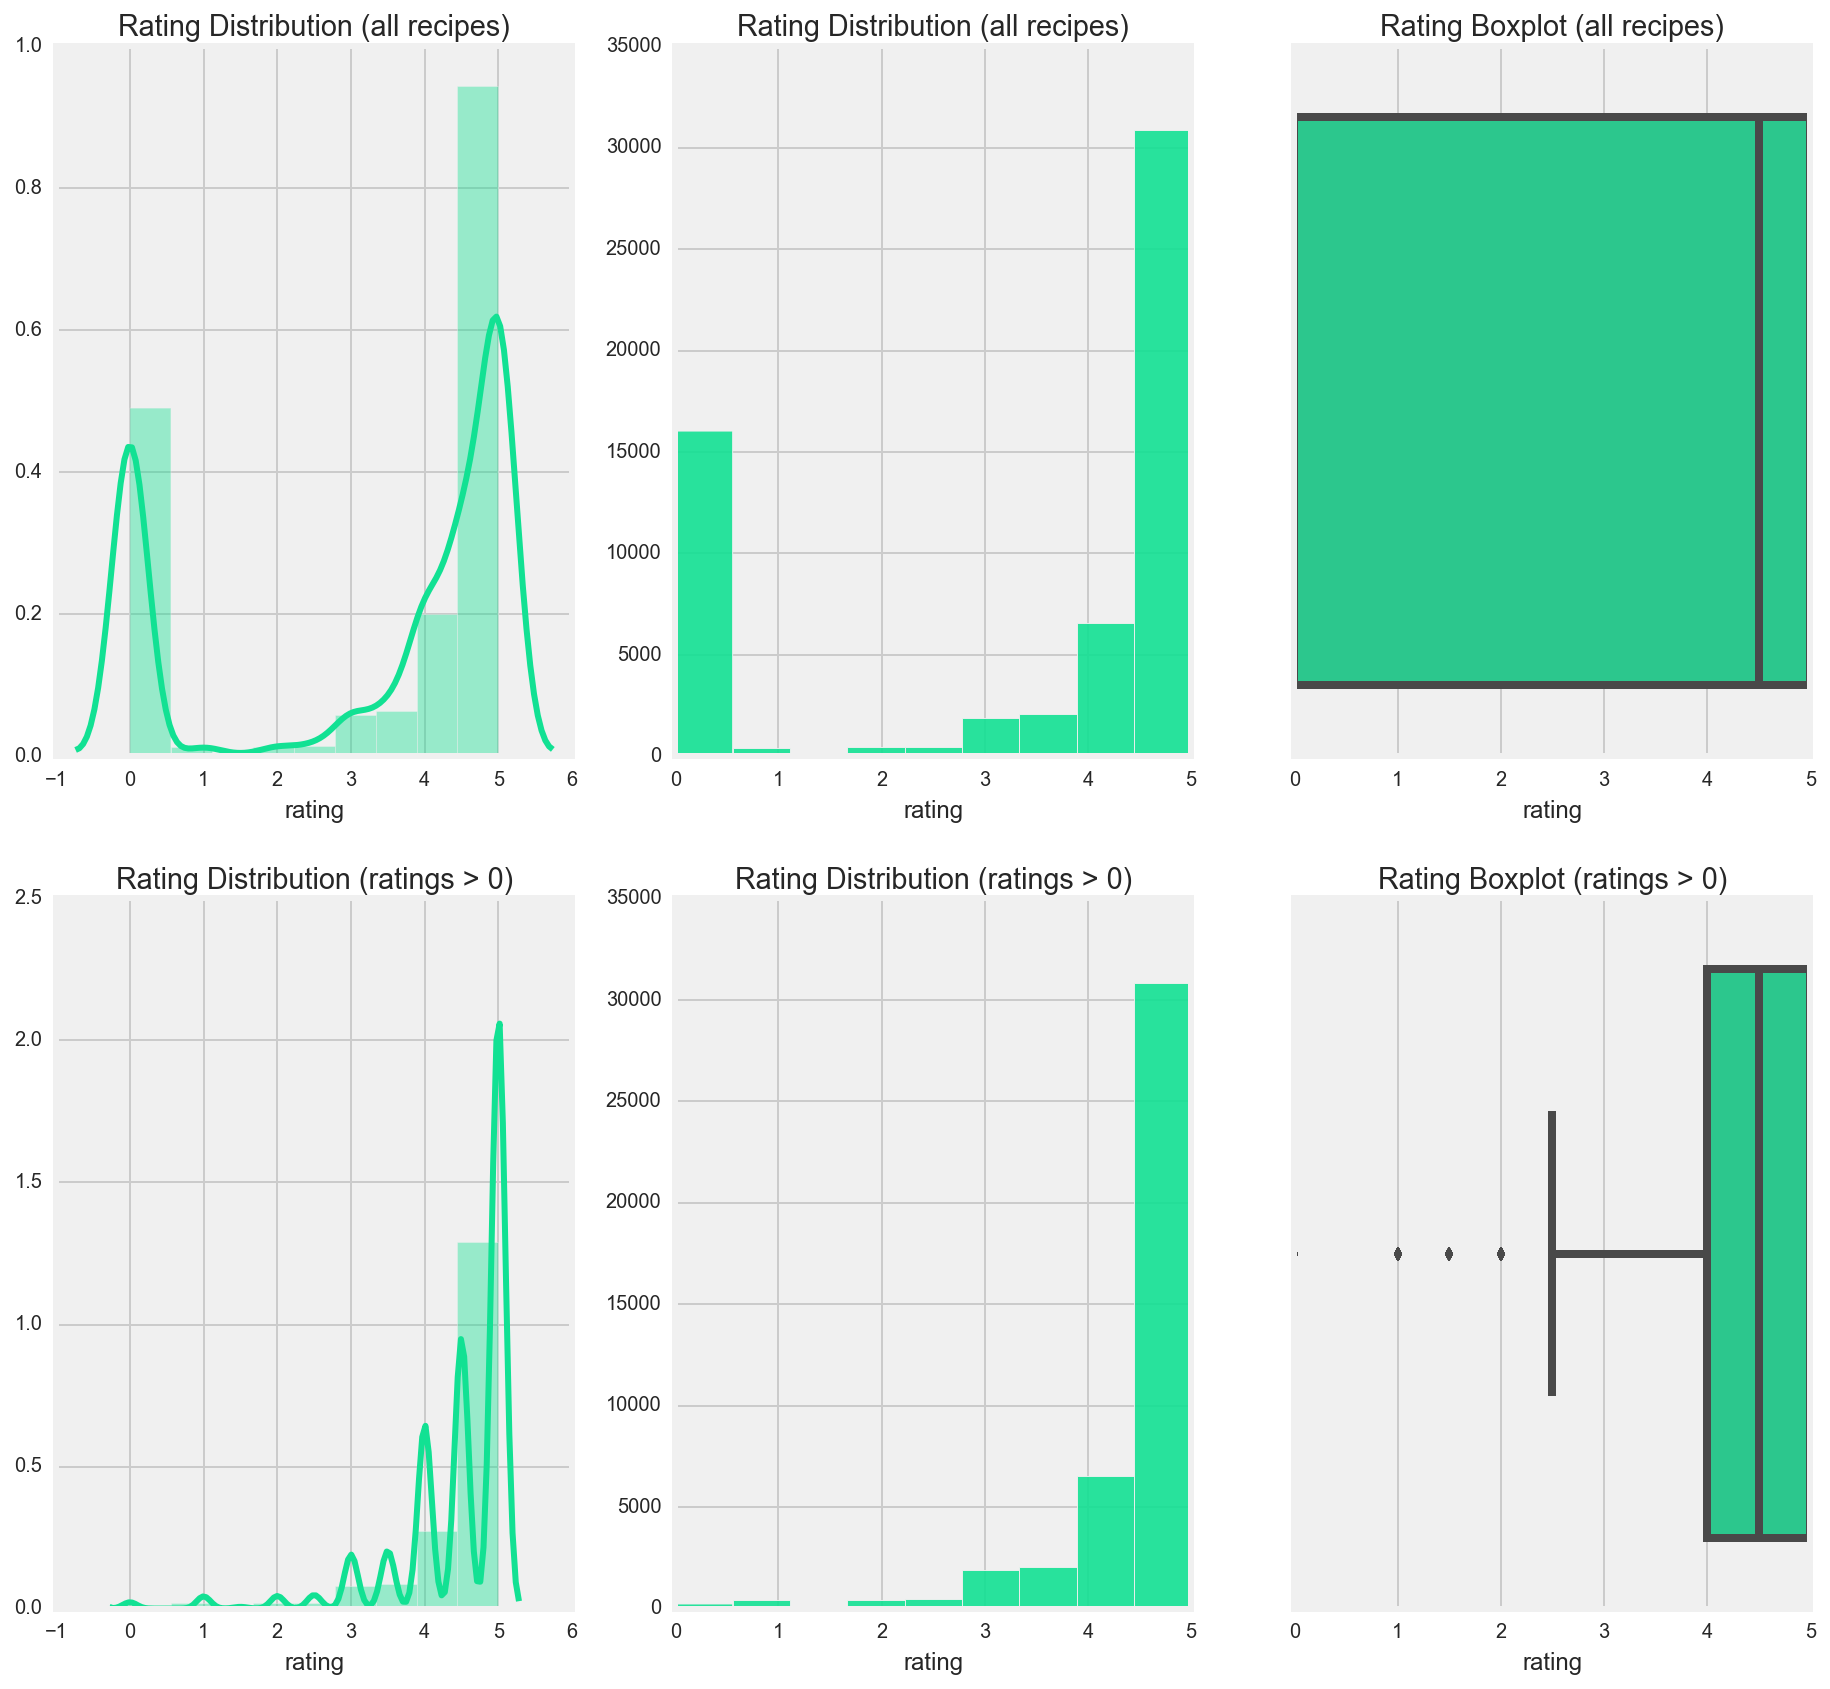

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,14))
random = colors[int(len(colors)*np.random.rand())]
# rating distribution
sns.distplot(df.rating, bins=9, hist=True, kde=True, kde_kws={"lw":3, 'shade':False}, 
             color=random, ax=axs[0,0])
sns.distplot(df.rating, bins=9, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[0,1])
sns.boxplot(x='rating', data=df, color=random, ax=axs[0,2])
# rating distribution for recipes with ratings > 0
sns.distplot(df_rs.rating, bins=9, hist=True, kde=True, kde_kws={"lw":3, 'shade':False},
             color=random, ax=axs[1,0])
sns.distplot(df_rs.rating, bins=9, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[1,1])
sns.boxplot(x='rating', data=df_rs, color=random, ax=axs[1,2])

axs[0,0].set_title('Rating Distribution (all recipes)')
axs[0,1].set_title('Rating Distribution (all recipes)')
axs[0,2].set_title('Rating Boxplot (all recipes)')
axs[1,0].set_title("Rating Distribution (ratings > 0)")
axs[1,1].set_title("Rating Distribution (ratings > 0)")
axs[1,2].set_title('Rating Boxplot (ratings > 0)')
plt.show()

### The 10 worst recipes on foodnetwork.com
Yes, a handful of recipes received 0-star ratings. What a shame and surprise that Mom's Spaghetti & Meatballs is literally the worst.

In [300]:
df[['name','chef','difficulty','ratings','rating']]\
[(df.ratings > 0) & (df.rating==0)].sort_values('ratings',ascending=False).head(10)

,name,chef,difficulty,ratings,rating
33382,MOM'S SPAGHETTI AND MEATBALLS,"adapted ""one dish at a time: delicious s my ...",Easy,6.0,0.0
33214,MOCHA POPS,food network kitchen,Easy,4.0,0.0
51648,STUFFED BLOODY MARY,geoffrey zakarian,Easy,4.0,0.0
48427,S'MORES DIP,food network kitchen,Easy,4.0,0.0
38764,PISTACHIO-COATED CHEESE LOG,patricia heaton parties,Easy,2.0,0.0
11345,CHOCOLATE CHIP COOKIE DOUGH TRUFFLES,food network kitchen,Easy,2.0,0.0
37937,PEPPERMINT CREAMS,lorraine pascale,Unknown,2.0,0.0
52322,SUNNY'S QUICK CHEESE PUFF SQUARES,sunny anderson,Easy,2.0,0.0
38652,PINK LEMONADE SHOTS,victoria belanger,Easy,2.0,0.0
9125,CHEESY MASHED POTATOES,nancy fuller,Easy,2.0,0.0


## Rating v Difficulty
When comparing rating distributions by difficulty level, there is almost no variance between them, suggesting that recipe rating is independent of difficulty level.

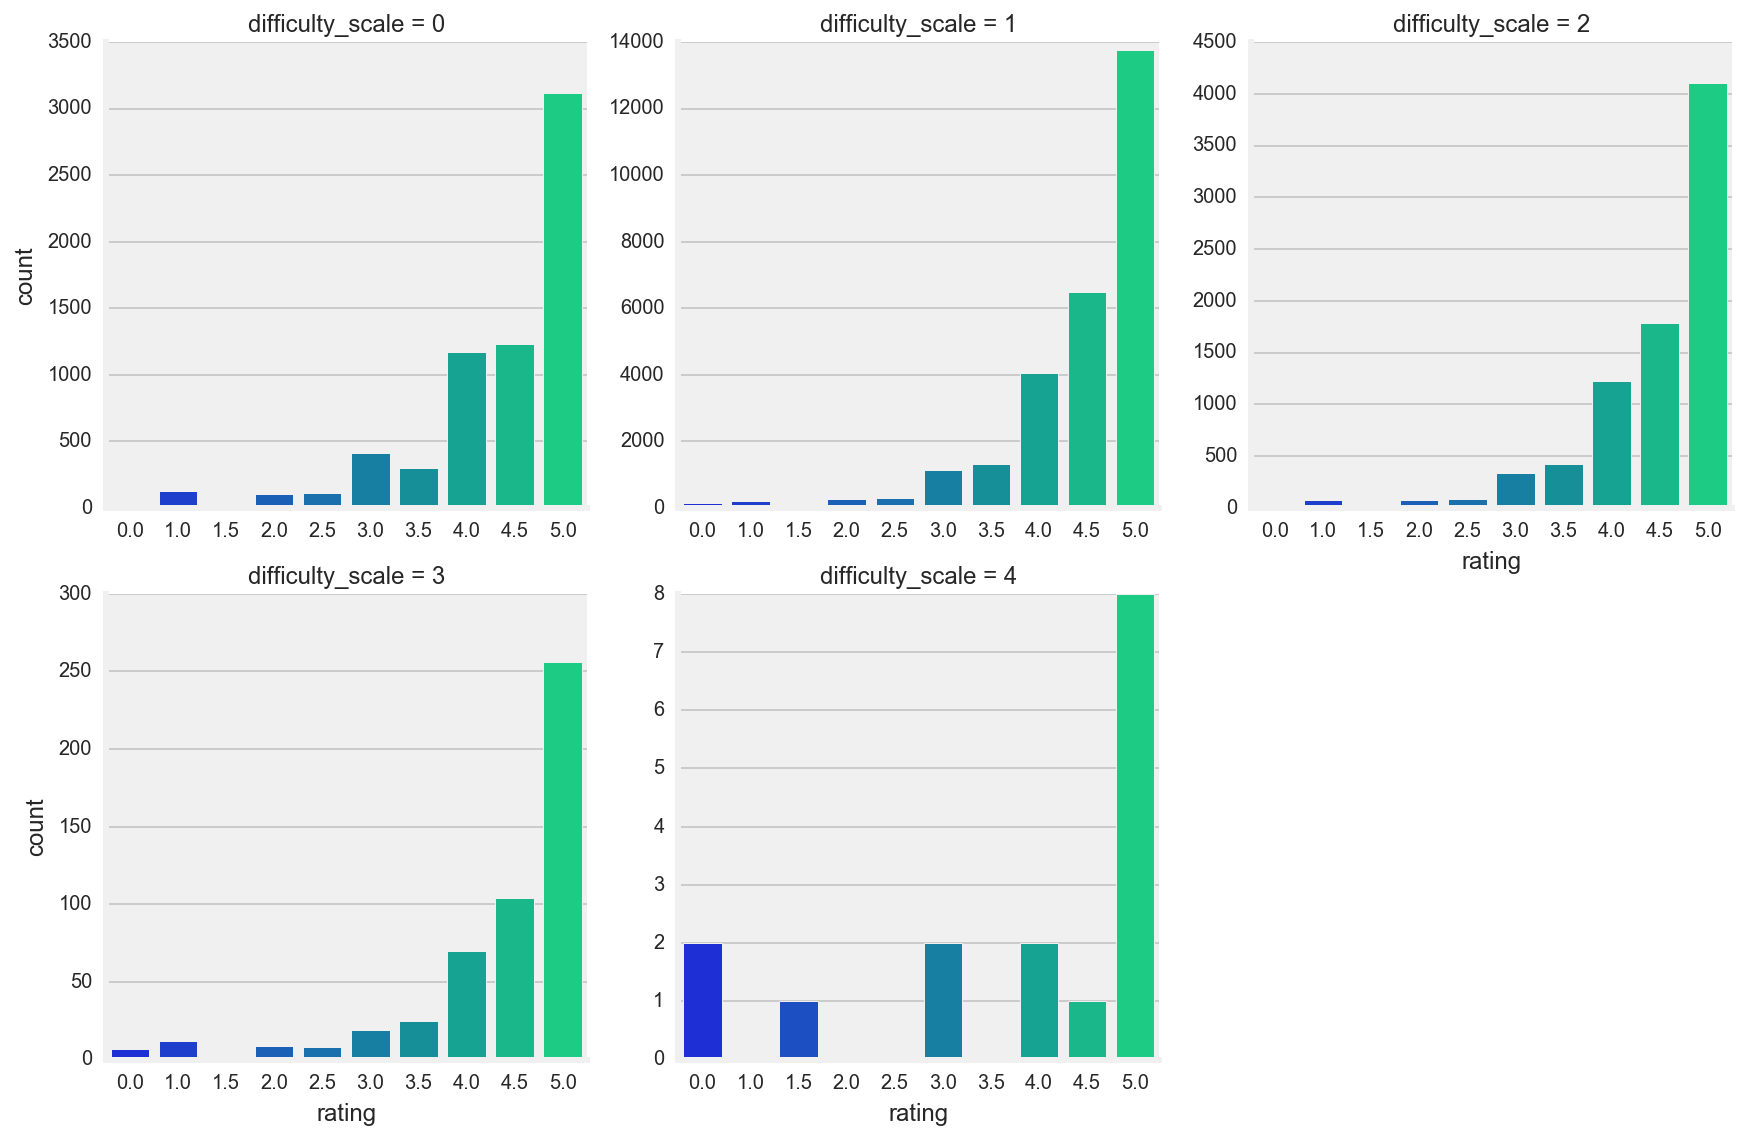

In [277]:
sns.factorplot(x="rating", data=df_rs, kind="count", palette="winter", col='difficulty_scale', col_wrap=3,
               sharex=False, sharey=False)
plt.show()

## Rating v Photo
As the logistic regression below suggests, recipes with a photo tend to recieve a higher rating. 

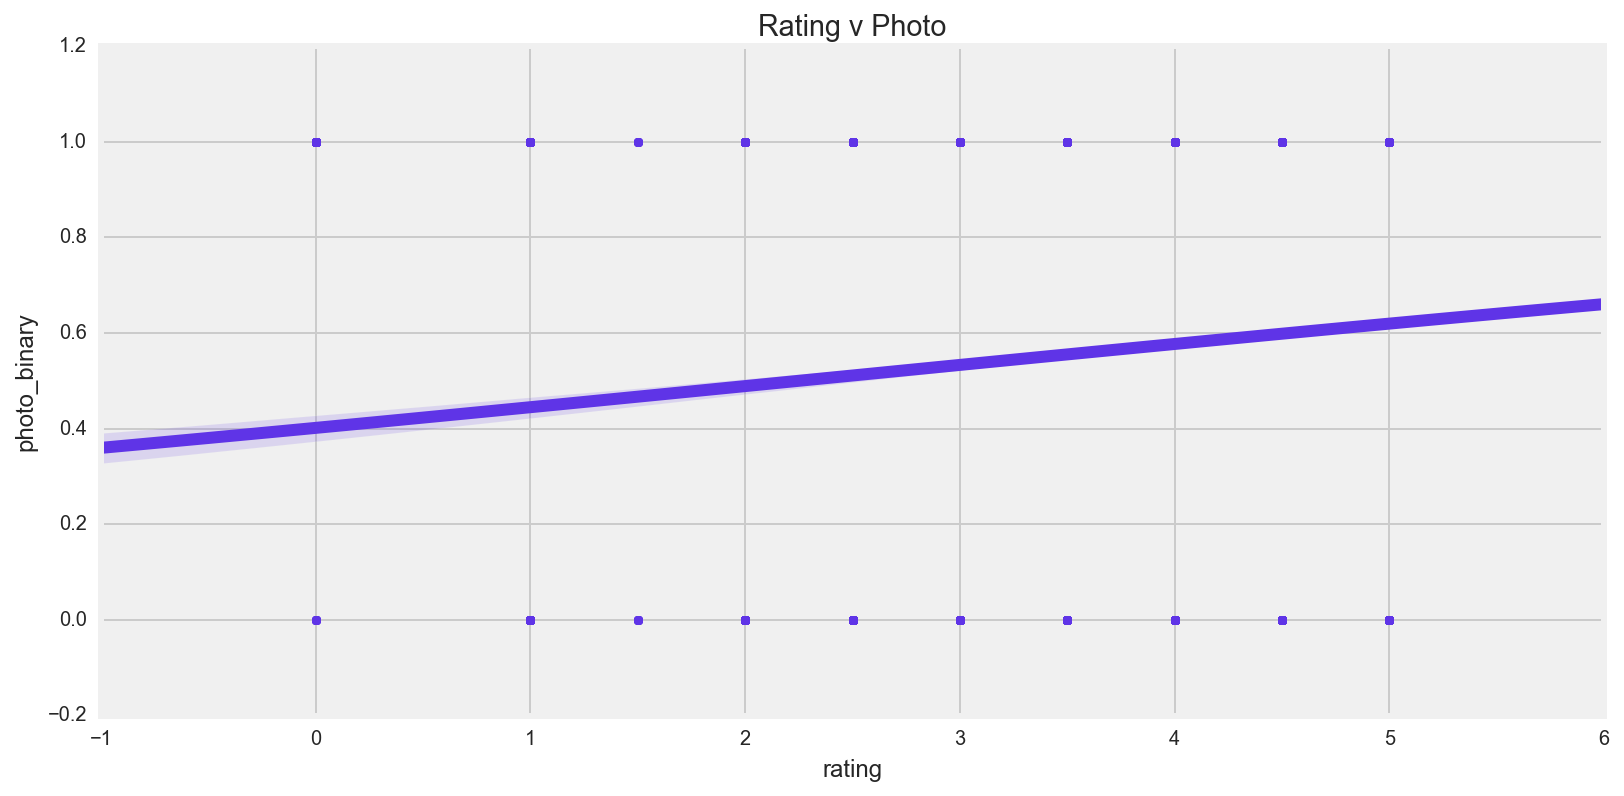

In [279]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="rating", y="photo_binary", data=df_rs, fit_reg=True, logistic=True, color=random)
ax.set_title('Rating v Photo')
plt.show()

<a id='difficulty'></a>
### <a href='#eda_table_of_contents'>back to EDA table of contents</a>

# Difficulty*

*<i>Recipe difficulty == Unknown (difficulty_scale == 0) is treated as its own special category</i>

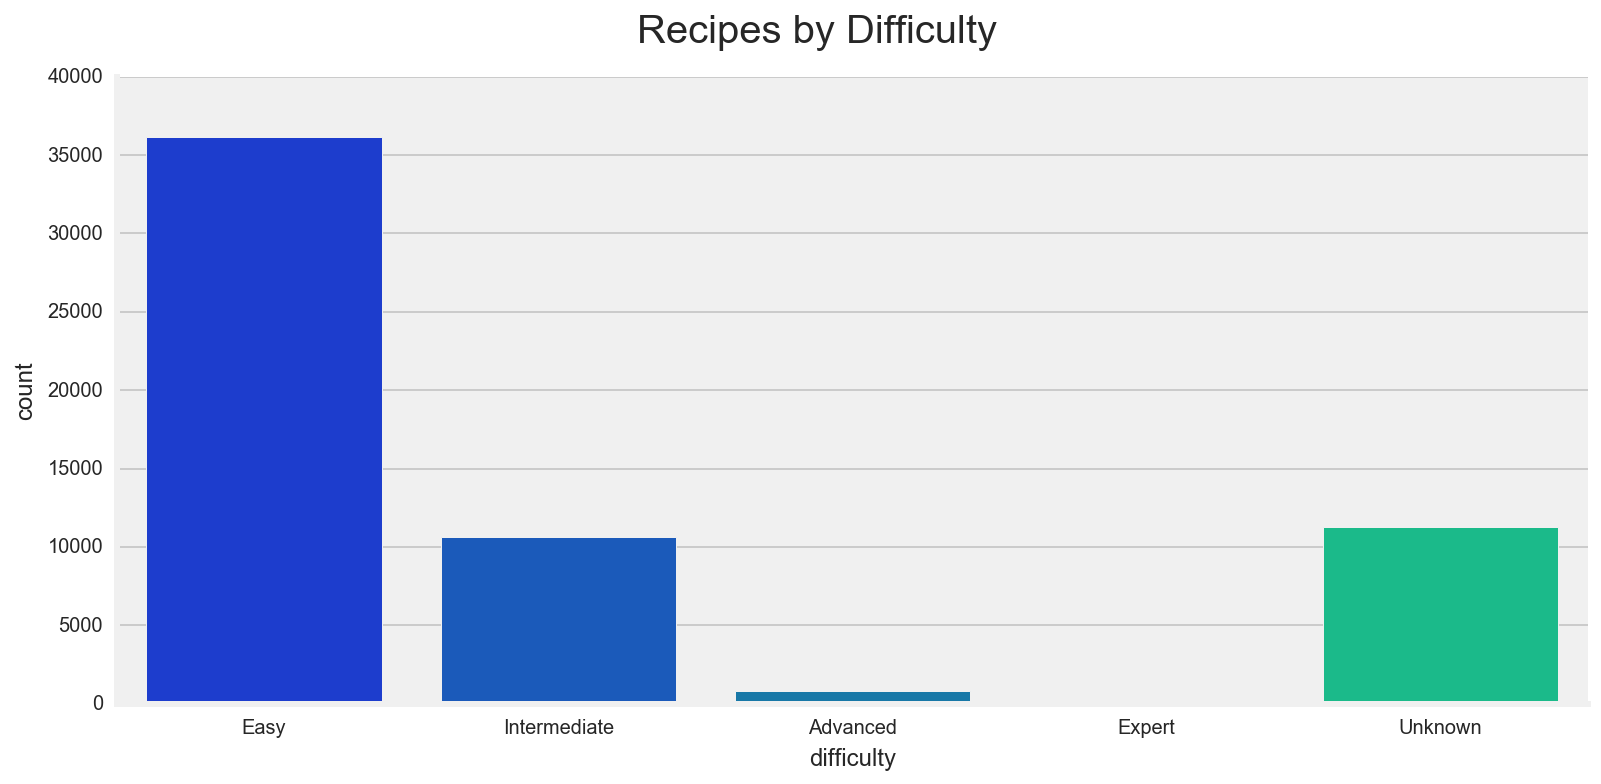

In [262]:
g = sns.factorplot(x="difficulty", data=df, kind="count", palette="winter", size=5.5, aspect=2, 
                   order=['Easy','Intermediate','Advanced','Expert','Unknown'])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Recipes by Difficulty', fontsize=20)
plt.show()

## Difficulty v Ingredients (number)
A fairly straightforward finding, difficulty increases with the number of ingredients in a recipe.

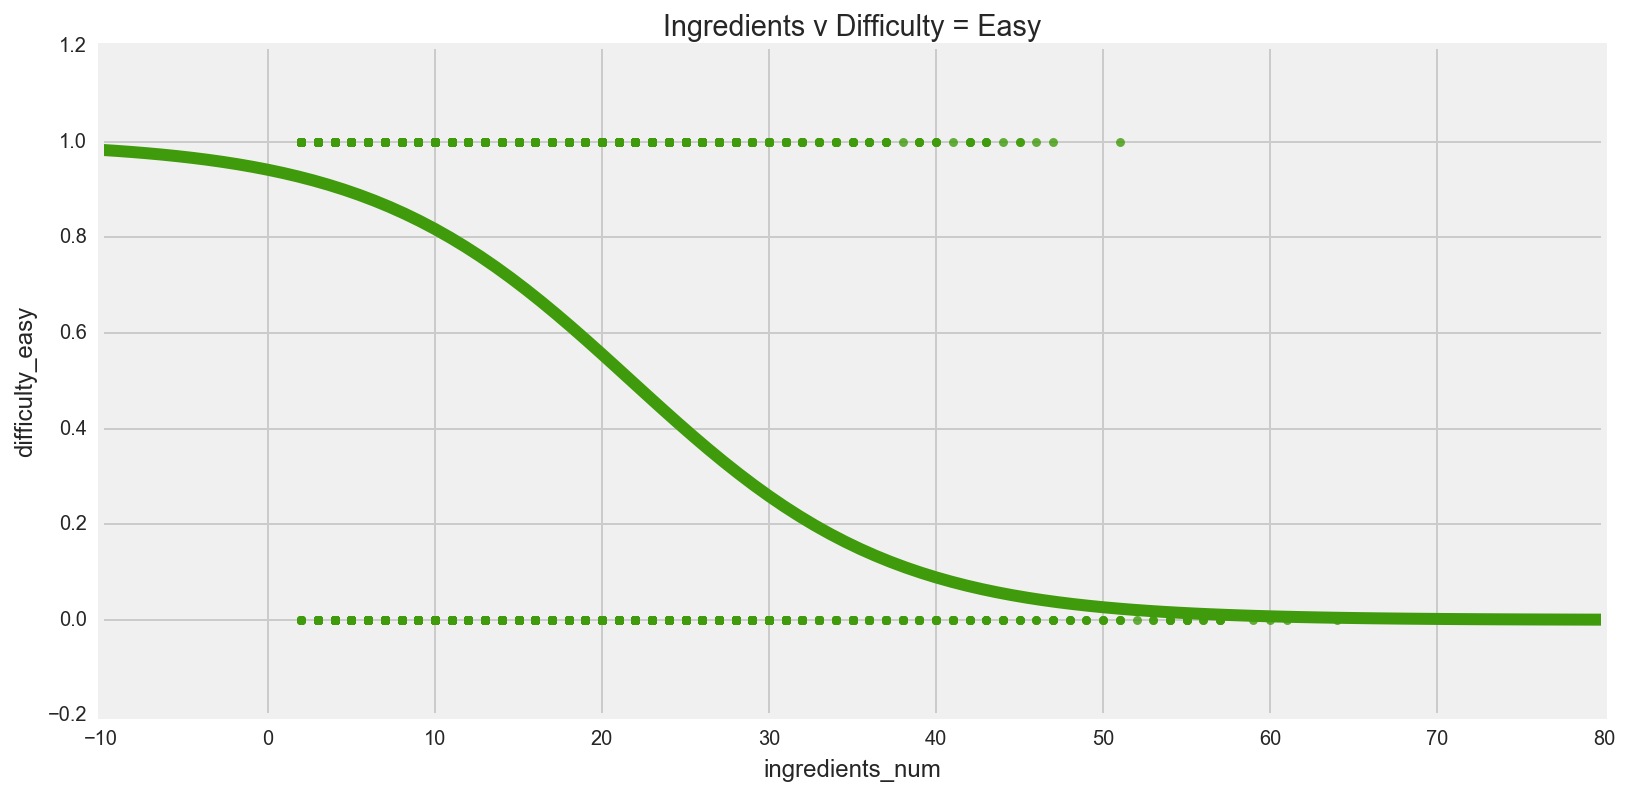

In [286]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_easy", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Easy')
plt.show()

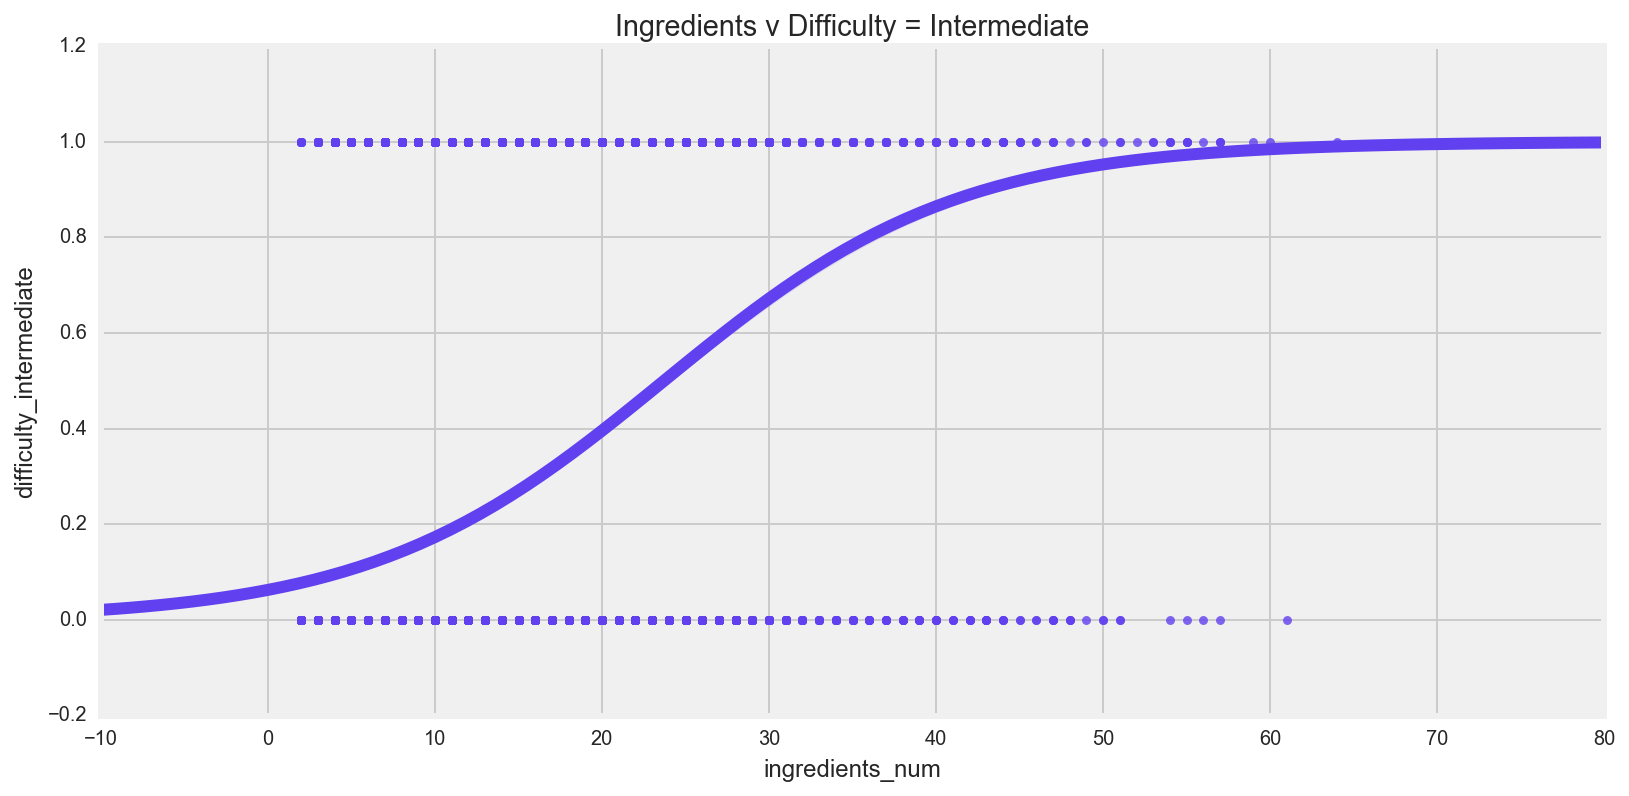

In [287]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_intermediate", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Intermediate')
plt.show()

<a id='ingredients'></a>
### <a href='#eda_table_of_contents'>back to EDA table of contents</a>

# Ingredients (number) 

Doing a quick overview of the ingredients category, we find a fairly normal distribution of ingredients, skewed slightly right. The most frequent number of ingredients in a recipe is 9 with 4,633 recipes, while 75% of recipes have 15 or fewer ingredients. The results are not too surprising here, it makes sense that the majority of recipes would have fewer ingredients. Below you can see the top 10 recipes with the most ingredients.


Mode: 9 ingredients - 4633 recipes 

count    58852.000000
mean        11.819292
std          6.288360
min          2.000000
25%          7.000000
50%         11.000000
75%         15.000000
max         71.000000
Name: ingredients_num, dtype: float64 



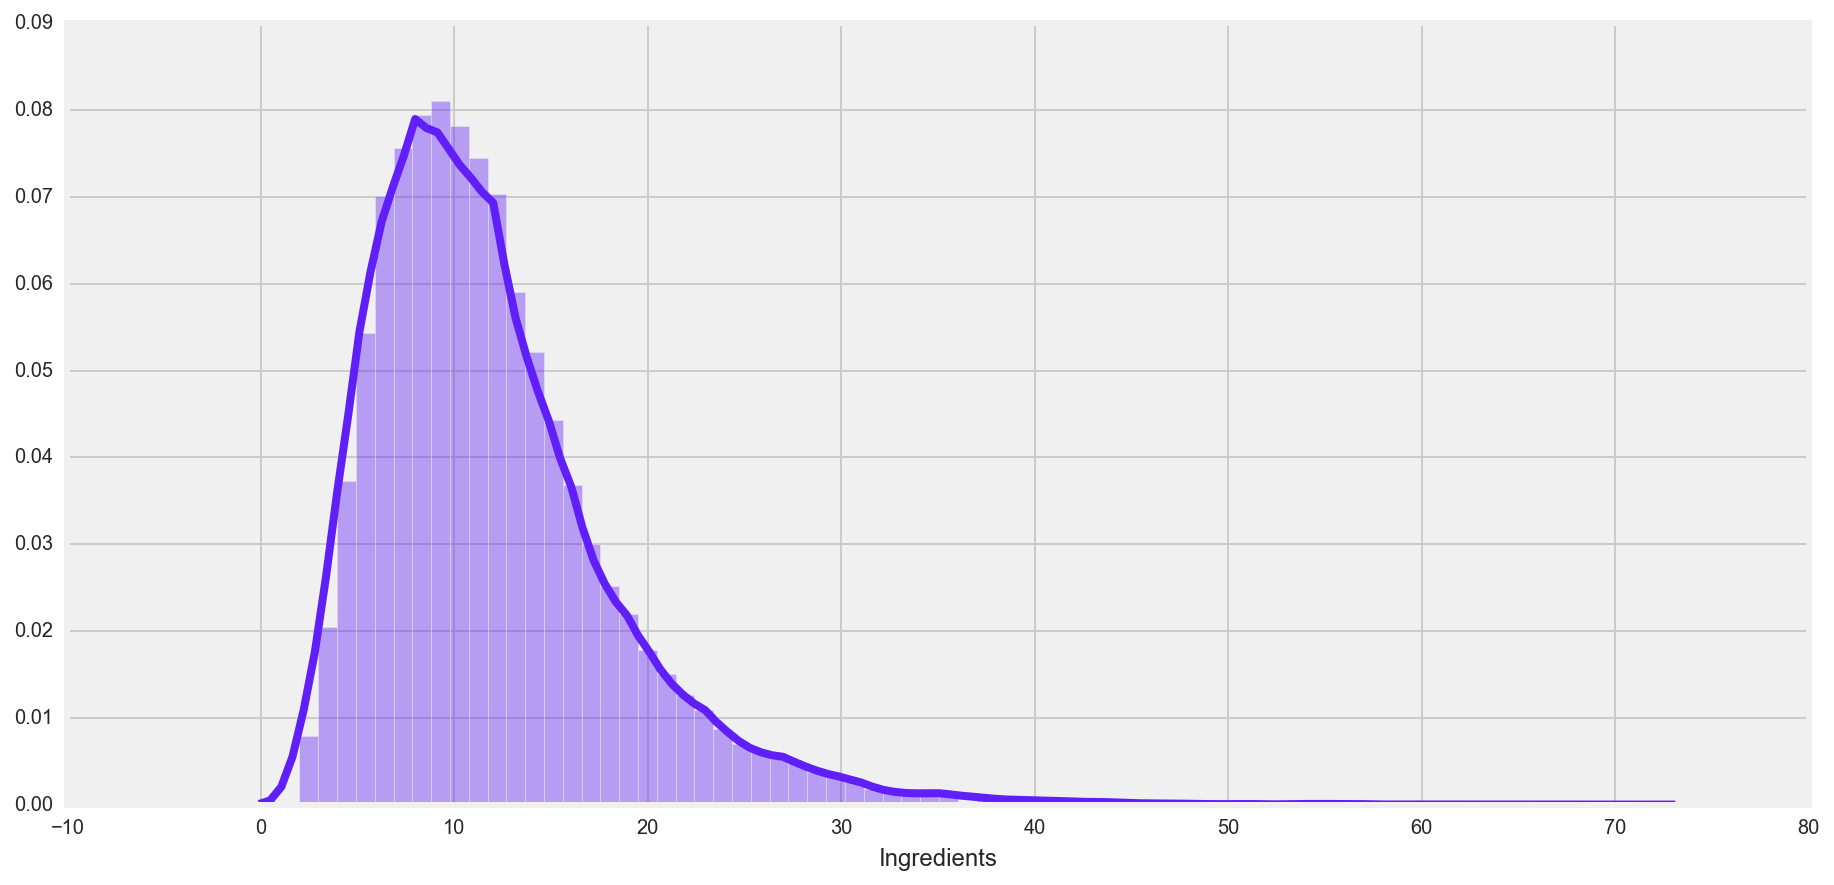

In [284]:
print '\nMode: 9 ingredients - %s recipes' % max(df.ingredients_num.value_counts()), '\n'
print df.ingredients_num.describe(), '\n'
# random color
random = colors[int(len(colors)*np.random.rand())]
fig, ax = plt.subplots(figsize=(13.9,7))
ax = sns.distplot(df.ingredients_num, bins=(df.ingredients_num.max()), hist=True, kde=True, axlabel="Ingredients",
                  color=random)
plt.show()

In [303]:
df[['name','chef','ingredients_num','difficulty','ratings','rating']]\
.sort_values('ingredients_num', ascending=False).head(10)

,name,chef,ingredients_num,difficulty,ratings,rating
41818,REBUILT LOUISIANA SEAFOOD PLATTER,frank brigtsen new orleans louisiana,71.0,Intermediate,0.0,0.0
20286,FRIED CHICKEN,bryan voltaggio,64.0,Intermediate,10.0,4.0
32615,MILK CHOCOLATE PALETTE WITH HONEY CRISP APPLES...,daniel humm,61.0,Advanced,0.0,0.0
24684,GRILLED SOY AND GINGER MARINATED RACK OF LAMB ...,wolfgang puck,60.0,Intermediate,2.0,5.0
41909,RED CURRY MARINATED SKIRT STEAK FAJITAS,bob flay,59.0,Intermediate,27.0,5.0
3132,BARBECUED PULLED PORK SANDWICHES WITH HOMEMADE...,emeril lagasse,57.0,Intermediate,146.0,5.0
29942,LIFE BURGER,life food gourmet,57.0,Intermediate,0.0,0.0
300,AHI PALETTE DANCER,james aptakin and vic vegas,57.0,Advanced,0.0,0.0
35791,OXTAIL AND BLACK BEAN SOUP WITH GRILLED SPINY ...,emeril lagasse,57.0,Intermediate,4.0,5.0
36964,PASTICCIO,mario batali,56.0,Unknown,3.0,5.0


<a id='modeling'></a>
### <a href='#eda_table_of_contents'>back to EDA table of contents</a>
### <a href='#table_of_contents'>back to Main table of contents</a>
# Modeling - Predict Rating (score) <a id='modeling_contents'></a>
To restate our assessment about the rating system: it is inherently flawed, given that a recipe with 1, 5-star rating has the same score as a recipe with 10, 5-star ratings, and has a better score than a recipe with 100, 4-star ratings. Additionally, the distribution for rating is so heavily favored towards 5-star ratings, that there isn't a proportional difference between each rating tier--in other words, the difference between a 5-star and 4-star rating is more significant than the difference between a 4-star and a 3-star, or a 3-star and a 2-star.  Lastly, 50% of the recipes on foodnetwork.com have 3 ratings or fewer, and a whopping 15,853 (26.94%) have no ratings at all. Our estimation on how best to approach the modeling followed from these assessments. 

Working under the pretext of a flawed rating system, and unreliable, if not incomplete dataset, we decided the best approach for predicting a recipe rating was a supervised, classification method, using recipes with 10 or more ratings as our training set. Because we are most interested in discovering the true or projected rating of the recipes with few or no ratings. 

- <a href='#kNN'>Logistic Regression, kNN</a>
- <a href='#decision_tree'>Decision Tree Classifier</a>
- <a href='#random_forest'>Random Forest</a>
- <a href='#random_forest_dummy'>Random Forest w/Category Dummy Variables

In [9]:
# linreg
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

# normalization
from sklearn.preprocessing import StandardScaler

# patsy
import patsy

<a id='kNN'></a>

## Logistic Regression, kNN 

Notes for Kiefer on next step:
- with the idea being to use the projected score in the whats_in_the_fridge app, how do I apply the models below on the entire set and assign the projected rating classifications to a new column?
- am I doing what you recommended accurately so far?


In [6]:
# logreg/kNN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [7]:
df['rating_classifier'] = df['rating'].map(lambda x: 2 if x == 5 
                                                else 1 if x == 4
                                                else 1 if x == 4.5
                                                else 0)

In [8]:
df['rating_classifier'].value_counts()

0    21431
2    21244
1    16177
Name: rating_classifier, dtype: int64

In [10]:
Xr = df[['ratings','time_cook','time_inactive','time_prep','time_total','ingredients_num','difficulty_scale',
         'difficulty_easy','difficulty_intermediate','difficulty_advanced','difficulty_expert',
         'difficulty_unknown','photo_binary','category_1_num','category_2_num','category_3_num',
         'directions_len']]

Xr_10 = Xr[Xr.ratings >= 10]

yr_10 = df[df.ratings >= 10].rating_classifier

ss = StandardScaler()
nXr_10 = ss.fit_transform(Xr_10)

In [156]:
lr_params = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.linspace(0.0001, 1000, 50)
            }

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

lr_gs.fit(nXr_10, yr_10)
print "Best LogReg Parameters:", lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   36.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished


Best LogReg Parameters: {'penalty': 'l1', 'C': 20.408261224489795, 'solver': 'liblinear'}


In [157]:
kNN_params = {'n_neighbors':range(3,10),
              'weights':['uniform','distance']
             }

knn_gs = GridSearchCV(KNeighborsClassifier(), kNN_params, cv=10, verbose=1)

knn_gs.fit(nXr_10, yr_10)

print 'Best kNN Parameters:', knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   35.0s


Best kNN Parameters: {'n_neighbors': 9, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.7min finished


In [158]:
nXr_10_tr, nXr_10_te, yr_10_tr, yr_10_te = train_test_split(nXr_10, yr_10, train_size=0.8, stratify=yr_10)
print nXr_10_tr.shape, yr_10_tr.shape
print nXr_10_te.shape, yr_10_te.shape

(13538, 17) (13538,)
(3385, 17) (3385,)


### How our classification models perform on the test set for recipes with 10 or more ratings

In [159]:
model_kNN = best_knn.fit(nXr_10_tr, yr_10_tr)
model_lr = best_lr.fit(nXr_10_tr, yr_10_tr)

predict_kNN = model_kNN.predict(nXr_10_te)
predict_lr = model_lr.predict(nXr_10_te)

kNN_score = model_kNN.score(nXr_10_te, yr_10_te)
lr_score = model_lr.score(nXr_10_te, yr_10_te)

kNN_report = classification_report(yr_10_te, predict_kNN)
lr_report = classification_report(yr_10_te, predict_lr)

print 'kNN Score:', kNN_score
print kNN_report, '\n'
print 'LogReg Score:', lr_score
print lr_report

kNN Score: 0.50694239291
             precision    recall  f1-score   support

          0       0.10      0.02      0.04       218
          1       0.46      0.47      0.46      1433
          2       0.55      0.60      0.58      1734

avg / total       0.48      0.51      0.49      3385


LogReg Score: 0.515805022157
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.45      0.22      0.29      1433
          2       0.53      0.83      0.65      1734

avg / total       0.46      0.52      0.46      3385



//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### How our classifcation models perform on the recipes with less than 10 ratings

In [164]:
Xr_9 = Xr[Xr.ratings < 10]
yr_9 = df[df.ratings < 10].rating_classifier

nXr_9 = ss.fit_transform(Xr_9)

predict_kNN_9 = model_kNN.predict(nXr_9)
predict_lr_9 = model_lr.predict(nXr_9)

kNN_score = model_kNN.score(nXr_9, yr_9)
lr_score = model_lr.score(nXr_9, yr_9)

kNN_report = classification_report(yr_9, predict_kNN_9)
lr_report = classification_report(yr_9, predict_lr_9)

print 'kNN Score:', kNN_score
print kNN_report, '\n'
print 'LogReg Score:', lr_score
print lr_report

kNN Score: 0.267714469699
             precision    recall  f1-score   support

          0       0.64      0.01      0.02     20339
          1       0.17      0.30      0.22      9013
          2       0.32      0.66      0.43     12577

avg / total       0.44      0.27      0.19     41929


LogReg Score: 0.277564454196
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     20339
          1       0.06      0.09      0.07      9013
          2       0.38      0.86      0.53     12577

avg / total       0.13      0.28      0.17     41929



### Assigning a projected clasifier score for each recipe

In [ ]:
# df['rating_logreg_predict'] = model_lr.predict(Xr)
# df['rating_kNN_predict'] = model_kNN.predict(Xr)

<a id='decision_tree'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Decision Tree Classifier 

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [11]:
Xr_10_tr, Xr_10_te, yr_10_tr, yr_10_te = train_test_split(Xr_10, yr_10, train_size=0.8, stratify=yr_10)
print Xr_10_tr.shape, yr_10_tr.shape
print Xr_10_te.shape, yr_10_te.shape

(13538, 17) (13538,)
(3385, 17) (3385,)


In [21]:
# initiate decision tree classifier
dctc = DecisionTreeClassifier()

## Search parameters
dtc_params = {'max_depth':[None,1,2,3,4],
              'max_features':[None,'log2','sqrt','auto', 2,3,4,5],
              'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
             }

## Gridsearch    
dtc_gs = GridSearchCV(dctc, dtc_params, n_jobs=-1, cv=5, verbose=1)

## fit
dtc_gs.fit(Xr_10_tr, yr_10_tr)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:   21.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 'auto', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [22]:
## Print best estimator, best parameters, and best score
dtc_best_estimator = dtc_gs.best_estimator_
print "best estimator\n", dtc_best_estimator

print "\n=========="
dct_best_param = dtc_gs.best_params_
print "best parameters\n",  dct_best_param 

print "\n=========="
print "best score\n", dtc_gs.best_score_


best estimator
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

best parameters
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}

best score
0.534347761856


In [23]:
## Predict
yr_10_pred= dtc_gs.predict(Xr_10_te)
print yr_10_pred.shape, yr_10_te.shape

(3385,) (3385,)


In [25]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

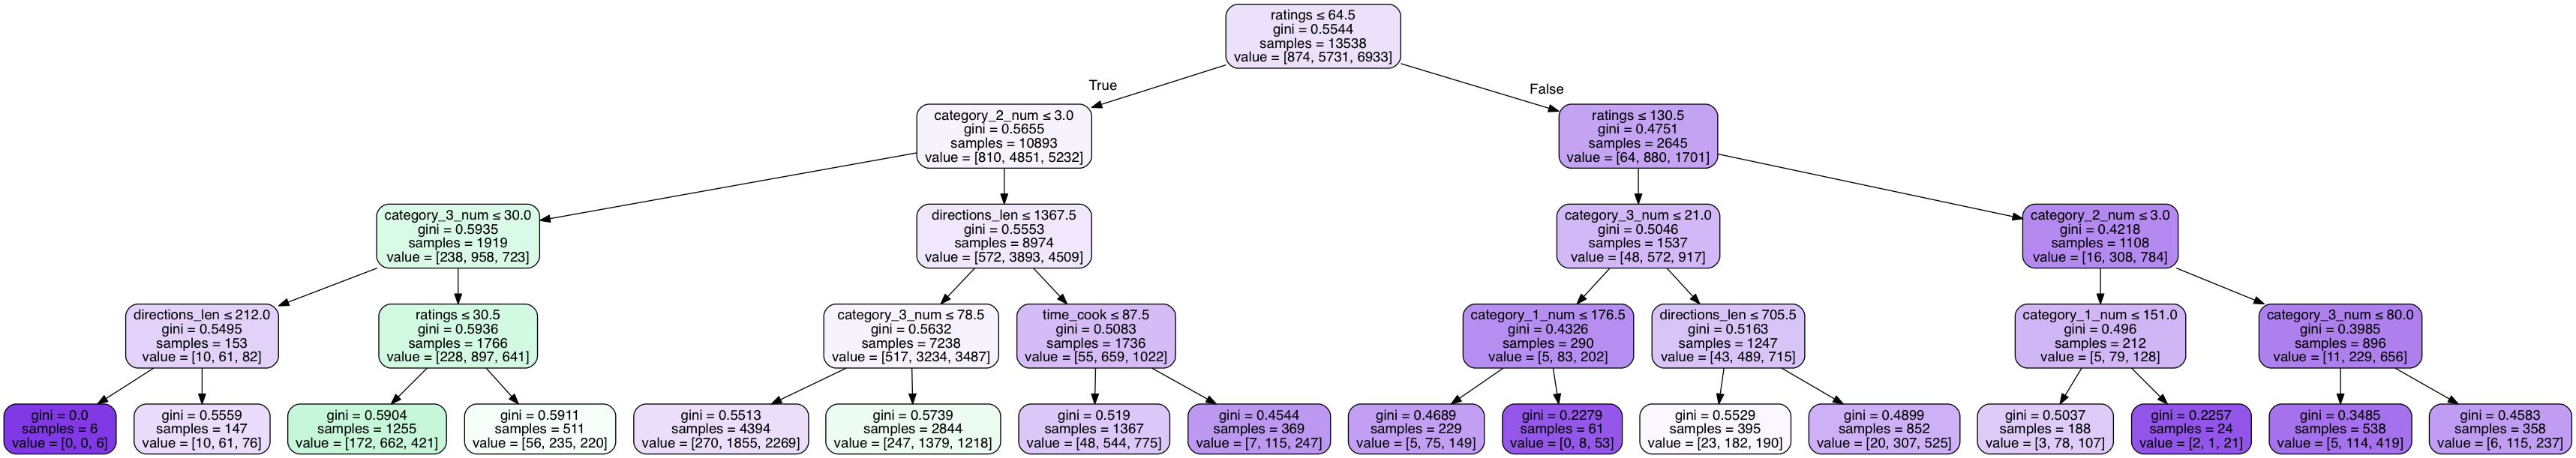

In [26]:
dot_data = StringIO()

## Define decision tree with best parameters, you can also use the best estimators
dctc_best= DecisionTreeClassifier(max_features= None, min_samples_split= 25, max_depth= 4)
                                    

## Fit the best estimators (X_train, y_train)
dctc_best.fit(Xr_10_tr, yr_10_tr)


## Graph
export_graphviz(dctc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xr.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [27]:
## Print Feature importances
feature_importance = pd.DataFrame({'feature':Xr.columns, 
                                   'importance':dctc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,ratings,0.450153
14,category_2_num,0.178251
15,category_3_num,0.165252
16,directions_len,0.145726
13,category_1_num,0.038530
1,time_cook,0.022088
4,time_total,0.000000
5,ingredients_num,0.000000
6,difficulty_scale,0.000000
7,difficulty_easy,0.000000


In [30]:
## Print a classification report
cls_rep = classification_report(yr_10_te, yr_10_pred)
print cls_rep 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.47      0.37      0.41      1433
          2       0.55      0.72      0.63      1734

avg / total       0.48      0.52      0.50      3385



//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id='random_forest'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Random Forest 

In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc1 = RandomForestClassifier(max_depth=1, n_estimators=10, random_state=1, n_jobs=1) 
rfc2 = RandomForestClassifier(max_depth=2,  n_estimators=10, random_state=1, n_jobs=1)
rfc3 = RandomForestClassifier(max_depth=3,  n_estimators=10, random_state=1, n_jobs=1)

In [47]:
## Define a Random Forest Classifier
rfc = RandomForestClassifier()

rf_params = {'max_features':[None,'log2','sqrt', 2,3,4,5],
             'max_depth':[1,2,3,None],
             'min_samples_leaf':np.linspace(1,101,20),
             'n_estimators':[100]
            }

## gridsearch parameters, and cv =5
rf_gs = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)

# fit
rf_gs.fit(Xr_10_tr, yr_10_tr)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 12.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'n_estimators': [100], 'max_depth': [1, 2, 3, None], 'min_samples_leaf': array([   1.     ,    6.26316,   11.52632,   16.78947,   22.05263,
         27.31579,   32.57895,   37.84211,   43.10526,   48.36842,
         53.63158,   58.89474,   64.15789,   69.42105,   74.68421,
         79.94737,   85.21053,   90.47368,   95.73684,  101.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [48]:
## Print best estimator, best parameters, and best score
rfc_best = rf_gs.best_estimator_
print "best estimator\n", rfc_best
print "\n=========="
print "best parameters\n", rf_gs.best_params_
print "\n=========="
print "best score\n", rf_gs.best_score_

best estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=64.15789473684211, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters
{'max_features': None, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 64.15789473684211}

best score
0.549933520461


In [49]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':Xr.columns, 
                                   'importance':rfc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,ratings,0.226568
15,category_3_num,0.157449
16,directions_len,0.141292
13,category_1_num,0.098934
14,category_2_num,0.098818
5,ingredients_num,0.077609
4,time_total,0.073738
1,time_cook,0.067870
3,time_prep,0.024805
2,time_inactive,0.016008


In [51]:
## Predict 
yr_10_pred_rfc= rfc_best.predict(Xr_10_te)
print yr_10_pred_rfc.shape, yr_10_te.shape

 (3385,) (3385,)


In [52]:
## Print classification report
cls_rep = classification_report(yr_10_te, yr_10_pred_rfc)
print cls_rep 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.49      0.38      0.43      1433
          2       0.56      0.74      0.64      1734

avg / total       0.50      0.54      0.51      3385



<a id='random_forest_dummy'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Random Forest with dummy variables for categories

In [16]:
categories = pd.read_csv('../data_clean/categories.csv')
categories['category'] = categories['0'].map(lambda x: x.lower() if x else '')

In [17]:
categories.head()

,Unnamed: 0,index,0,category
0,0,1,Bourbon,bourbon
1,1,2,Dessert,dessert
2,2,3,Apple,apple
3,3,4,Side Dish,side dish
4,4,5,Sauce,sauce


In [18]:
df_ = df
df_.shape

(58852, 31)

In [19]:
for value in categories.category:
    df_[value] = ''

In [20]:
df_.shape

(58852, 455)

In [21]:
for col in df_.columns[31:]:
    df_[col] = df_['category_1'].map(lambda x: 1 if x == col else 0)
    df_[col][df_[col] != 1] = df_['category_2'].map(lambda x: 1 if x == col else 0)
    df_[col][df_[col] != 1] = df_['category_3'].map(lambda x: 1 if x == col else 0)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
df_['easy'].value_counts()

0    53856
1     4996
Name: easy, dtype: int64

In [23]:
df_.columns[31:]

Index([u'bourbon', u'dessert', u'apple', u'side dish', u'sauce', u'fruit',
       u'easy', u'whole wheat', u'pizza dough', u'heart healthy',
       ...
       u'honeydew', u'rosh hashanah', u'millet', u'lebanese', u'low fat',
       u'labor day', u'low carbohydrate', u'venezuelan', u'eel', u'turkish'],
      dtype='object', length=424)

In [52]:
df_.columns[:31]

Index([u'categories', u'chef', u'difficulty', u'directions', u'ingredients',
       u'name', u'photo', u'rating', u'ratings', u'time_cook',
       u'time_inactive', u'time_prep', u'time_total', u'url', u'yield_',
       u'ingredients_num', u'difficulty_scale', u'difficulty_easy',
       u'difficulty_intermediate', u'difficulty_advanced',
       u'difficulty_expert', u'difficulty_unknown', u'photo_binary',
       u'category_1', u'category_2', u'category_3', u'category_1_num',
       u'category_2_num', u'category_3_num', u'directions_len',
       u'rating_classifier'],
      dtype='object')

In [53]:
df_.shape

(58852, 455)

In [55]:
Xr = df_[[col for col in df.columns if col not in ['categories','chef','difficulty','directions','ingredients',
                                                    'name','photo','url','yield_','category_1','category_2',
                                                    'category_3','rating','rating_classifier','category_1_num',
                                                    'category_2_num','category_3_num']]]
yr = df_.rating_classifier

In [56]:
Xr_ = Xr
yr_ = yr

In [57]:
print Xr_.shape, yr_.shape

(58852, 438) (58852,)


In [58]:
Xr_ = Xr_[Xr_.ratings >= 10]
yr_ = df_[df_.ratings >= 10].rating_classifier

In [59]:
print Xr_.shape, yr_.shape

(16923, 438) (16923,)


In [37]:
trainXr_, testXr_, trainyr_, testyr_ = train_test_split(Xr_, yr_, train_size=0.8, stratify=yr_)
print trainXr_.shape, trainyr_.shape
print testXr_.shape, testyr_.shape

(13538, 438) (13538,)
(3385, 438) (3385,)


In [38]:
## Define a Random Forest Classifier
rfc = RandomForestClassifier()

rf_params = {'max_features':[None,'log2','sqrt', 2,3,4,5],
             'max_depth':[1,2,3,None],
             'min_samples_leaf':np.linspace(1,101,20),
             'n_estimators':[100]
            }

## gridsearch parameters, and cv =5
rf_gs = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)

# fit
rf_gs.fit(trainXr_, trainyr_)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 29.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'n_estimators': [100], 'max_depth': [1, 2, 3, None], 'min_samples_leaf': array([   1.     ,    6.26316,   11.52632,   16.78947,   22.05263,
         27.31579,   32.57895,   37.84211,   43.10526,   48.36842,
         53.63158,   58.89474,   64.15789,   69.42105,   74.68421,
         79.94737,   85.21053,   90.47368,   95.73684,  101.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [40]:
## Print best estimator, best parameters, and best score
rfc_best = rf_gs.best_estimator_
print "best estimator\n", rfc_best
print "\n=========="
print "best parameters\n", rf_gs.best_params_
print "\n=========="
print "best score\n", rf_gs.best_score_

best estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1.0, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters
{'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1.0}

best score
0.553922292805


In [42]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':Xr_.columns, 
                                   'importance':rfc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(15)

,feature,importance
13,directions_len,0.094441
0,ratings,0.093659
4,time_total,0.073921
5,ingredients_num,0.072029
1,time_cook,0.066923
3,time_prep,0.054000
2,time_inactive,0.032839
12,photo_binary,0.015682
6,difficulty_scale,0.011467
32,dinner,0.009932


### Apply random forest model to test set

In [43]:
## Predict 
predictions_testyr_ = rfc_best.predict(testXr_)
print predictions_testyr_.shape, testyr_.shape

(3385,) (3385,)


In [44]:
## Print classification report
cls_rep = classification_report(testyr_, predictions_testyr_)
print cls_rep 

             precision    recall  f1-score   support

          0       0.33      0.01      0.02       218
          1       0.51      0.44      0.47      1433
          2       0.58      0.71      0.64      1734

avg / total       0.53      0.55      0.53      3385



### Apply Random Forest model to dataset save results as a new variable in the recipes dataset and save dataset as a new .csv we can use in our whats_in_the_fridge app

In [62]:
model_rfc = rfc_best.fit(Xr_, yr_)
df_['rating_rfc_predict'] = model_rfc.predict(Xr)

In [69]:
## Predict / Classification report
predictions_full = model_rfc.predict(Xr)

## Print classification report
cls_rep = classification_report(yr, predictions_full)
print cls_rep 

             precision    recall  f1-score   support

          0       0.95      0.05      0.10     21431
          1       0.44      0.70      0.54     16177
          2       0.50      0.75      0.60     21244

avg / total       0.65      0.48      0.40     58852



In [63]:
df_['rating_rfc_predict'].value_counts()

2    31763
1    25881
0     1208
Name: rating_rfc_predict, dtype: int64

In [66]:
df_['rating_rfc_predict_rating'] = df_['rating_rfc_predict'].map(lambda x: 5. if x == 2
                                                                      else 4. if x == 1
                                                                      else 3.)

In [67]:
df_['rating_rfc_predict_rating'].value_counts()

5.0    31763
4.0    25881
3.0     1208
Name: rating_rfc_predict_rating, dtype: int64

<a id='whats_in_the_fridge'></a>
### <a href='#table_of_contents'>Table of Contents</a>

# VI. whats_in_the_fridge 
Now to address our first problem statement, and the inspiration for this project. We started this project because we saw a feature and information gap in the online recipe space--it's easy to find a recipe you want to make, but what recipes are available to you given the ingredients you have. As fans of foodnetwork.com, with their extensive library of curated recipes from celebrity chefs, this was the prime candidate for our project. After an exhaustive data collection, cleaning and munging effort, and countless iterations and tinkering with our final function, we were able to produce a function that returns recipes from keywords <i>and</i> ingredients supplied by the user. 

Our whats_in_the_fridge function has four basic steps:
1. subset the recipe database as ingredient-keywords are added
2. sort the results based on the user's preference
3. graph key metrics for the final list of recipes
4. print out a list of the recipes, their details, and urls

## Step 1: Subset
The challenge in this step was subsetting our dataset by searching multiple columns with different data types. To do this we initiated a while-loop that uses the built-in python function 'raw_input', which takes a input from the user while the function is running and converts it to a string. We then used that string to search for matches in the 'name', 'categories', and 'ingredients' columns, appending the rows and indexes to a list. Lastly, we concatanate and merge those lists where appropriate, and finally subset the entire dataset. We built in safeguards to prevent the dataset from subsetting to zero if an invalid keyword or ingredient was entered. After each valid subset (or input) the function tells the user how many recipes remain. To break the while-loop, we simply added a provision where if the input from the user is a blank string, our function moves on to the next step.  

## Step 2: Sort
This step is simple, the function just asks the user to select an ordering method, using a numeric variable. If an invalid key is entered, then the sorting function defaults to the projected rating for a recipe and moves on to graphing.

## Step 3: Graph
For the graphing section we decided to go with seaborn's barplot. It was the simplest choice for graphing multiple barplots horizontally, and includes a nice error bar in the event that two recipes have the same name. In this step our function takes the final subset of data and graphs the recipes by 6 key features:
- User ratings (popularity)
- User rating (score)
- Projected rating
- Time to complete
- Number of Ingredients
- Difficulty

## Step 4: Print details
The last step in our function, and probably the simplest, we simply loop through the recipes in the final subset of data and print out all the interesting info. 

## Step 5: nom nom 
Below is the code and some examples of our final function in use. You can also use the following link to view the full <a href='https://github.com/kylemullet/projects/blob/master/whats_in_the_fridge/whats_in_the_fridge.ipynb'>source code</a>. We hope you find it as cool and useful as we do. 

### <a href='#table_of_contents'>Table of Contents</a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
recipes = pd.read_csv('../data_clean/recipes_cleanest_w_model_predict.csv')
recipes.drop(['Unnamed: 0'], axis=1, inplace=True)

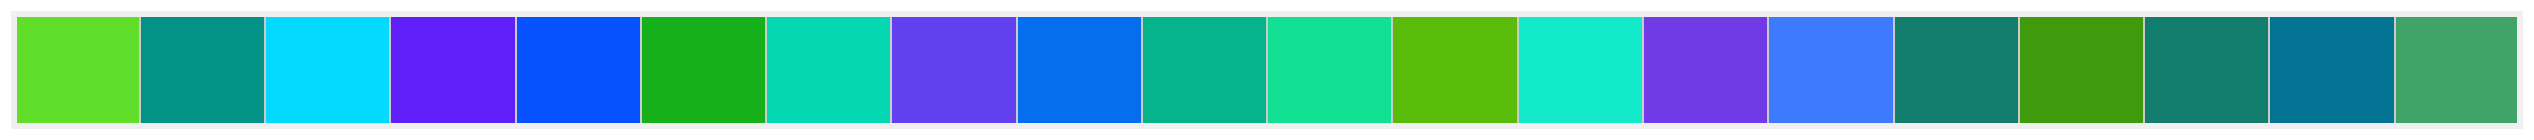

In [4]:
colors = ['#61de2a','#029386','#04d9ff','#601ef9','#0652ff','#15b01a','#04d8b2','#6140ef','#056eee','#06b48b',
          '#12e193','#58bc08','#13eac9','#703be7','#3d7afd','#137e6d','#3f9b0b','#137e6d','#047495','#40a368']
sns.palplot(colors)

In [5]:
def whats_in_the_fridge(data):

#####################################################################
    # narrow the number of recipes in our dataframe by search input
    # using the search input to subset the recipes dataframe
    # based on keyword matches in recipe name, categories, or ingredients
#####################################################################

    print '\n================================================================\n'
    print "- Search recipes by ingredient, cuisine, type of food, or keyword!"
    print " (e.g. tomato, salmon, mushroom, pizza, breakfast, asian, philly, carbonara, red velvet, scramble, etc.)"
    print "- Add as many ingredients/categories/keywords as you want!"
    print "- Once satisfied with the number recipes you have, hit 'return' to see your results\n\n---------------"
    
    # initiate a while loop for processing category input based on the shape of recipes    
    while True:
        
        # raw input for category
        keyword = raw_input('Search: ')
        keyword = keyword.lower()
        keyword_name = keyword.upper()
        
        # initiate a list to keep track of keyword matches in recipes.name
        # will use this later to subset recipes and merge with category matches
        indx_name = [[i,x] for i,x in enumerate(data.name) if x.find(keyword_name) != -1]
        indices_name = [i for i,x in indx_name]
        
        # do the same for keyword matches in recipes.ingredients
        indx_ingredients = [[i,x] for i,x in enumerate(data.ingredients) if x.find(keyword) != -1]
        indices_ingredients = [i for i,x in indx_ingredients]
        
        # combine the two lists of indices
        indices = indices_name
        for i in indices_ingredients:
            if i not in indices:
                indices.append(i)
            else:
                pass 
        
        # if the search input is blank ("") break the while loop and proceed to sorting/graphing
        if keyword == '':
            data = data
            print 'Gathering recipes...\n'
            time.sleep(1)
            break
        
        # if search input is not a valid value in either name, ingredients or categories, go back through the loop
        elif data[(data.category_1.isin([keyword])|
                   data.category_2.isin([keyword])|
                   data.category_3.isin([keyword]))].shape[0] == 0 and len(indices) == 0:
            
            print 'No matches for "%s"!' % keyword, '\n---------------'
        
        # else, if search input is a valid value in name, ingredients, or categories,
        # subset data to include recipes with that keyword
        else:
            data_category = data[(data.category_1.isin([keyword])|
                                  data.category_2.isin([keyword])|
                                  data.category_3.isin([keyword]))]
            
            data_keyword = data.iloc[indices,:]
            data = pd.merge(data_keyword, data_category, how='outer')
            print '%s recipes: ' % keyword, data.shape[0], '\n---------------'
    
    print '================================================================'  

#####################################################################
    # sort results
#####################################################################
    
    # prompt the user for an ordering method
    print "Select an ordering method:\n"
    print "1 --> user ratings (popularity)\n2 --> user rating (quality)\n3 --> projected rating\
    \n4 --> time\n5 --> ingredients\n6 --> difficulty\nhit 'return' to skip\n"
    
    sort_method = raw_input('Ordering Method: ')
    
    print '\n================================================================\n'

    # sort recipes based on the sorting method requested, else, sort by # of ratings
    if sort_method == '4':
        data = data.sort_values('time_total', ascending=True)
    elif sort_method == '6':
        data = data.sort_values('difficulty_scale', ascending=True)
    elif sort_method == '5':
        data = data.sort_values('ingredients_num', ascending=True)
    elif sort_method == '2':
        data = data.sort_values('rating', ascending=False)
    elif sort_method == '1':
        data = data.sort_values('ratings', ascending=False)
    elif sort_method == '3':
        data= data.sort_values('rating_rfc_predict', ascending=False)
    else:
        data = data.sort_values('ratings', ascending=False)

#####################################################################
    # graph everything
#####################################################################

    # initiate a graphs list for looping through
    graphs = ['ratings','rating','rating_rfc_predict_rating','time_total','ingredients_num','difficulty_scale']

    # initiate figure with subplots and tight_layout() so they are not stacked on top of each other
    f, axs = plt.subplots(6, figsize=(8,12))
    f.tight_layout()
    # adds extra distance on top of each graph for separation between axis & title
    f.subplots_adjust(top=1.5)

    # loop through graphs and plot each one
    for i, col in enumerate(graphs):
        sns.barplot(x=col, y='name', data=data, palette=colors, ax=axs[i])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')

    # set the title & range for each graph
    axs[0].set_title('Ratings')
    axs[1].set_title('Rating (0-5)')
    axs[1].set_xlim([0,5])
    axs[2].set_title('Projected Rating (3-5)')
    axs[2].set_xlim([0,5])
    axs[3].set_title('Total Time (minutes)')
    axs[4].set_title('Ingredients')
    axs[5].set_title('Difficulty (1=Easy, 2=Intermediate, 3=Advanced, 4=Expert, 0=Unknown)')
    axs[5].set_xlim([0,4])

    plt.show()

    print '================================================================'
    print 'Recipe List\n================================================================'
    
    for i in range(data.shape[0]):
        print data.iloc[i,5]
        print data.iloc[i,12], '\n'
        
    print '================================================================'
    print 'Recipe Details\n================================================================'
    
#####################################################################
    # print everything
#####################################################################

    # print out all pertinent info on each recipe
    for i in range(data.shape[0]):
        print data.iloc[i,5], '\nfrom', data.iloc[i,1].upper(), '\n' # Name and chef
        print 'Projected Rating: %s' % data.iloc[i,20]
        print 'Rating: ', data.iloc[i,6]
        print 'Ratings: ', data.iloc[i,7], '\n'
        print 'Yield: ', data.iloc[i,13], '\n'
        print 'Ingredients: ', (int(data.iloc[i,14])), '\n'
        print 'Difficulty Level:', data.iloc[i,2]
        print '       Prep Time: %s' % data.iloc[i,10]
        print '   Inactive Time: %s' % data.iloc[i,9]
        print '       Cook Time: %s' % data.iloc[i,8]
        print '           Total: %s minutes' % data.iloc[i,11]
        print '\n', data.iloc[i,12], '\n' # url
        print '================================================================\n'
        



- Search recipes by ingredient, cuisine, type of food, or keyword!
 (e.g. tomato, salmon, mushroom, pizza, breakfast, asian, philly, carbonara, red velvet, scramble, etc.)
- Add as many ingredients/categories/keywords as you want!
- Once satisfied with the number recipes you have, hit 'return' to see your results

---------------
Search: corn
corn recipes:  8240 
---------------
Search: not a real thinglakdsjflaksjdf;akldjsf
No matches for "not a real thinglakdsjflaksjdf;akldjsf"! 
---------------
Search: carrot
carrot recipes:  914 
---------------
Search: potato
potato recipes:  187 
---------------
Search: onion
onion recipes:  164 
---------------
Search: pepper
pepper recipes:  156 
---------------
Search: beef
beef recipes:  65 
---------------
Search: soup
soup recipes:  8 
---------------
Search: 
Gathering recipes...

Select an ordering method:

1 --> user ratings (popularity)
2 --> user rating (quality)
3 --> projected rating    
4 --> time
5 --> ingredients
6 --> difficult

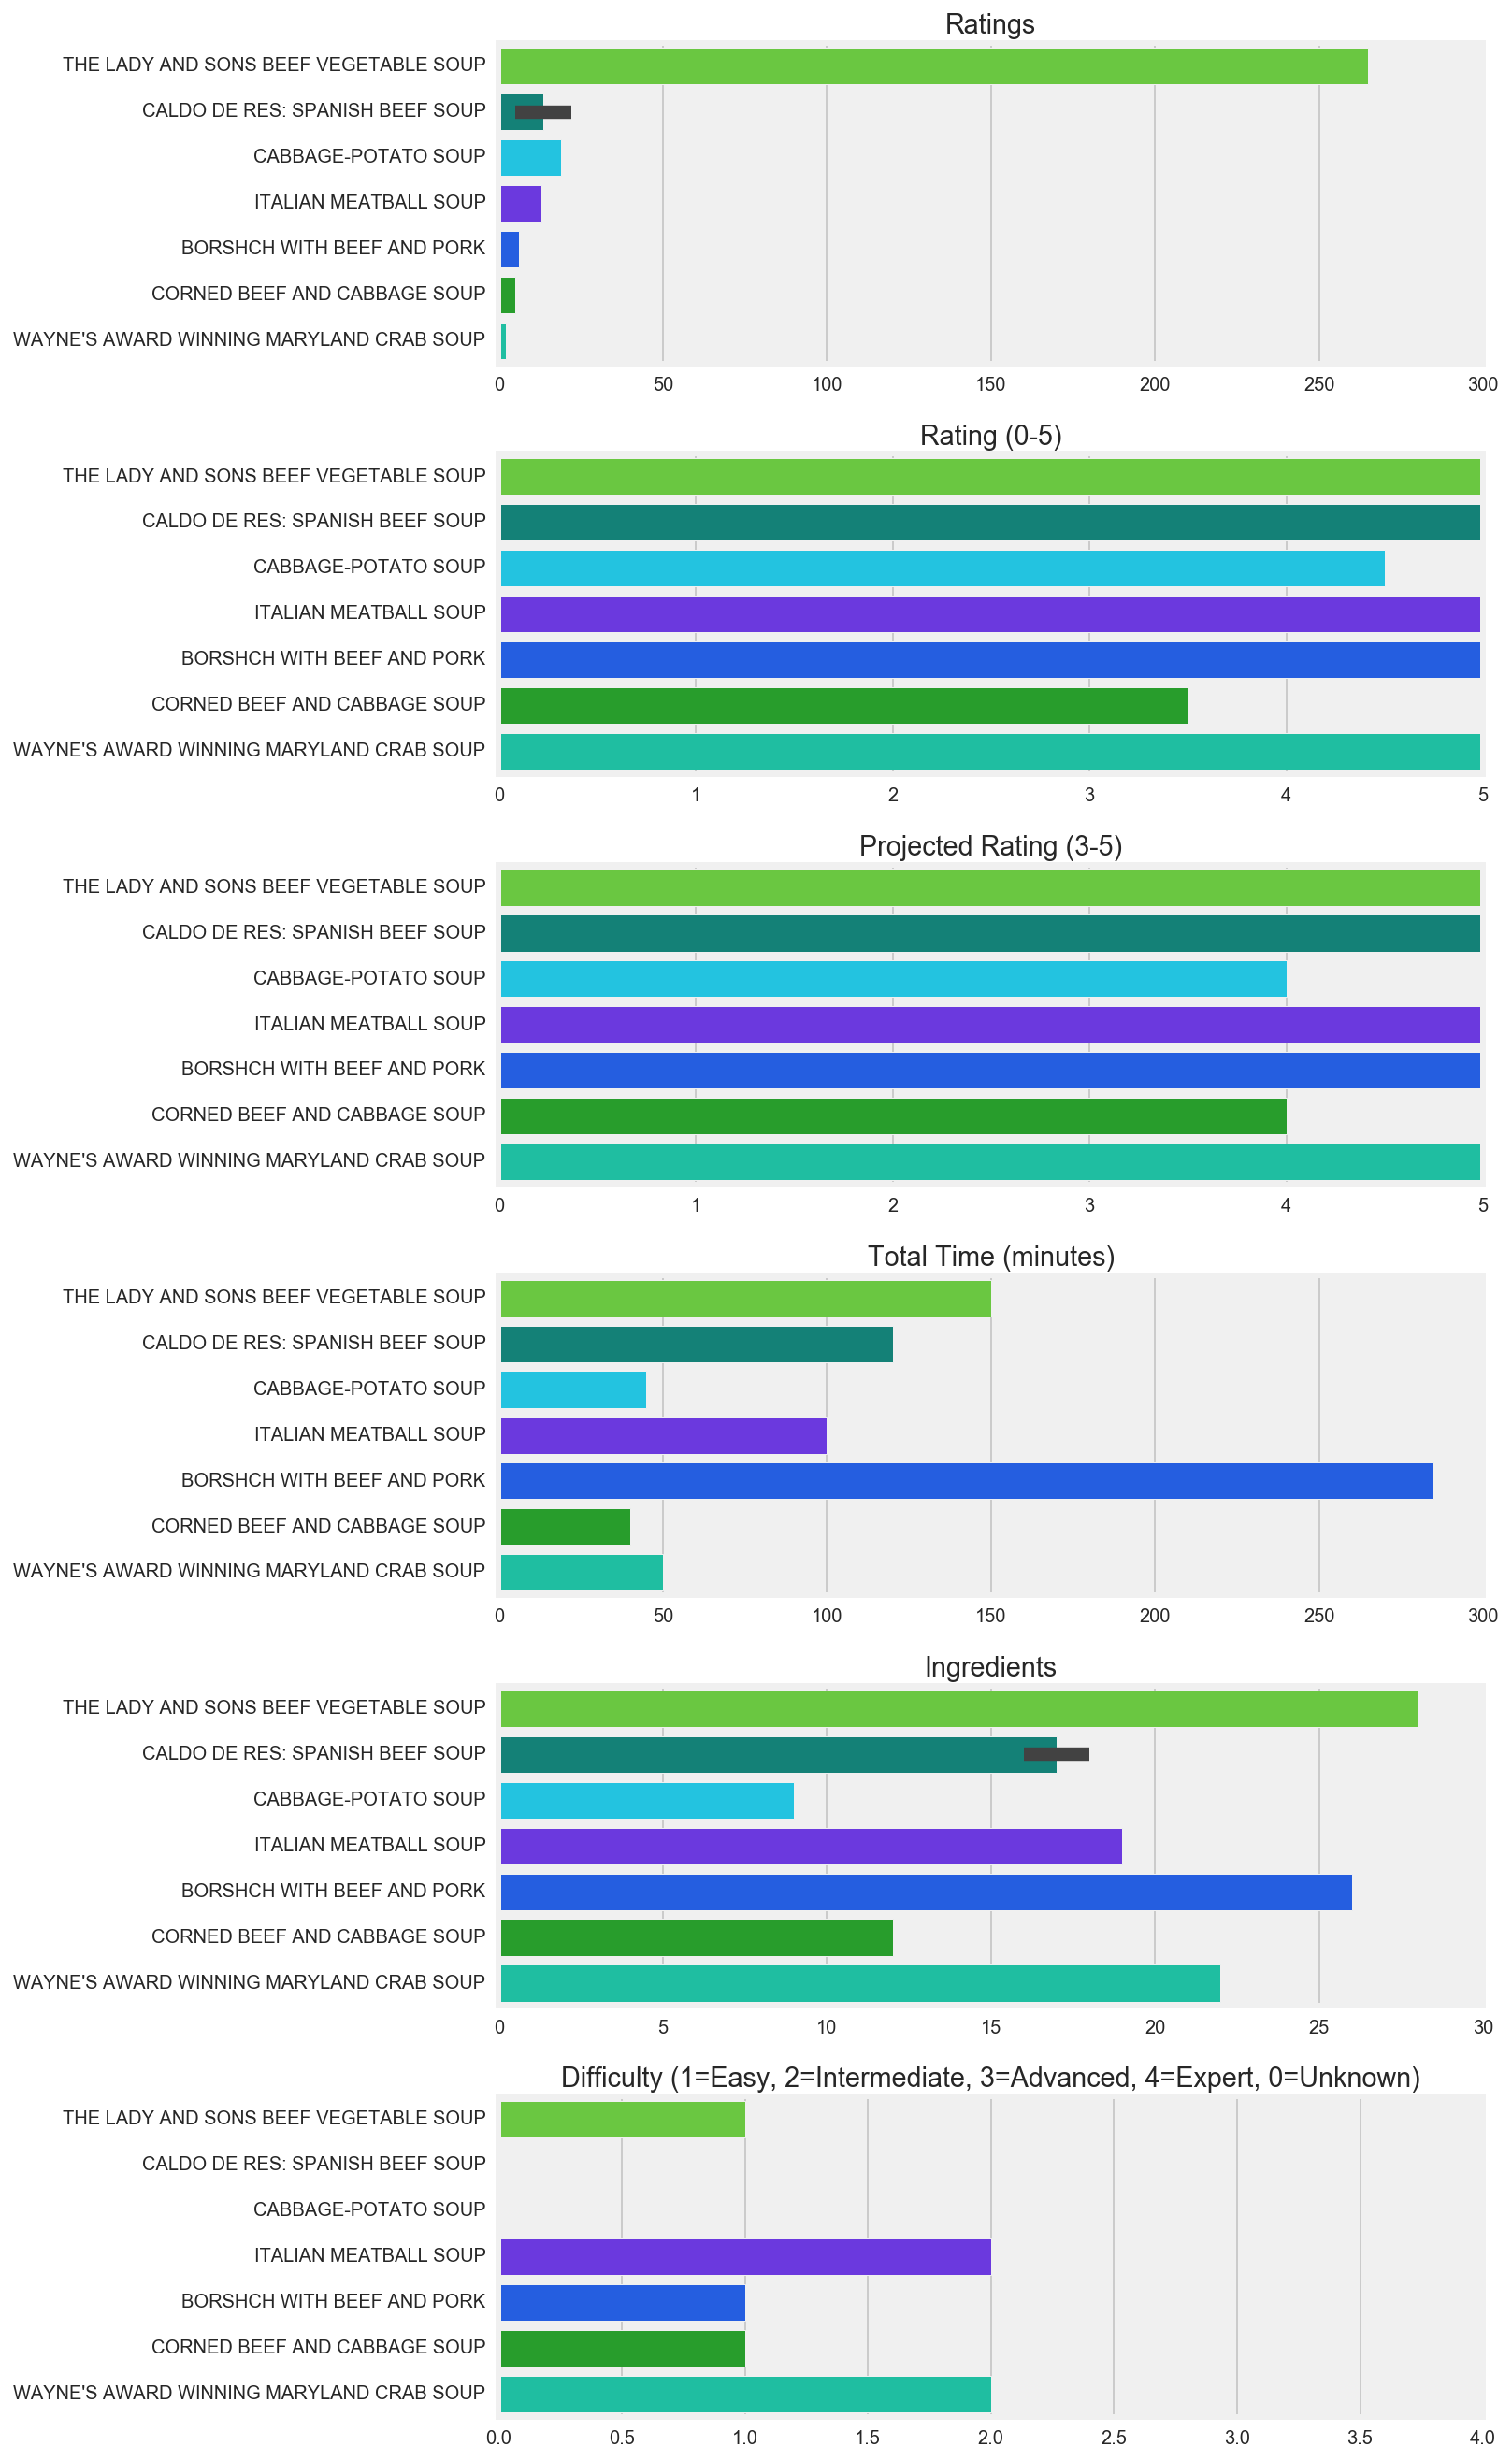

Recipe List
THE LADY AND SONS BEEF VEGETABLE SOUP
http://www.foodnetwork.com/recipes/paula-deen/the-lady-and-sons-beef-vegetable-soup-recipe.html 

CALDO DE RES: SPANISH BEEF SOUP
http://www.foodnetwork.com/recipes/caldo-de-res-spanish-beef-soup-recipe2.html 

CABBAGE-POTATO SOUP
http://www.foodnetwork.com/recipes/emeril-lagasse/cabbage-potato-soup-recipe.html 

ITALIAN MEATBALL SOUP
http://www.foodnetwork.com/recipes/ree-drummond/italian-meatball-soup.html 

BORSHCH WITH BEEF AND PORK
http://www.foodnetwork.com/recipes/borshch-with-beef-and-pork-recipe.html 

CORNED BEEF AND CABBAGE SOUP
http://www.foodnetwork.com/recipes/food-network-kitchens/corned-beef-and-cabbage-soup-recipe.html 

CALDO DE RES: SPANISH BEEF SOUP
http://www.foodnetwork.com/recipes/caldo-de-res-spanish-beef-soup-recipe.html 

WAYNE'S AWARD WINNING MARYLAND CRAB SOUP
http://www.foodnetwork.com/recipes/paula-deen/waynes-award-winning-maryland-crab-soup-recipe.html 

Recipe Details
THE LADY AND SONS BEEF VEGETABLE SOU

In [6]:
whats_in_the_fridge(recipes)